In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # 挂载 Google Drive

Mounted at /content/drive


In [ ]:
pip install tsfel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.6 MB/s eta 0:00:00


# 【1】HistGradientBoosting + PCA (0.58)

In [ ]:
# ========================
# Imports
# ========================
import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy import interpolate

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, balanced_accuracy_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.base import SamplerMixin


import matplotlib.pyplot as plt


# 可选：TSFEL
import tsfel
_cfg = tsfel.get_features_by_domain()
TSFEL_CFG = {"temporal": _cfg["temporal"], "spectral": _cfg["spectral"]}

SEED = 42
rng_global = np.random.default_rng(SEED)

# ========================
# 1) 基础工具：特征函数（TSFEL + 4 自定义）
# ========================
def _spectral_centroid_and_edge(x, fs_hz, edge_percent=0.9):
    f, Pxx = welch(x, fs=fs_hz, nperseg=min(len(x), 256))
    Pxx = np.clip(Pxx, 1e-12, None)
    sc = float(np.sum(f * Pxx) / np.sum(Pxx))
    cumsum = np.cumsum(Pxx) / np.sum(Pxx)
    idx = int(np.searchsorted(cumsum, edge_percent))
    idx = min(idx, len(f)-1)
    sef = float(f[idx])
    return sc, sef

def _jerk_stats(x, fs_hz):
    j = np.diff(x) * fs_hz
    if j.size == 0:
        return 0.0, 0.0
    jm = float(np.mean(j))
    js = float(np.std(j, ddof=1)) if j.size > 1 else 0.0
    return jm, js

def _coef_var(x):
    m = float(np.mean(x))
    if abs(m) < 1e-8:
        return 0.0
    return float(np.std(x, ddof=1) / abs(m))

def featurize_windows_tsfel_plus(X, colnames, fs_hz):
    rows = []
    for n in range(X.shape[0]):
        w = X[n]                       # (T, D)
        df_w = pd.DataFrame(w, columns=colnames)

        # TSFEL（整窗）
        tsfel_df = tsfel.time_series_features_extractor(
            TSFEL_CFG, df_w, fs=fs_hz, window_size=None, verbose=0
        )
        tsfel_df.reset_index(drop=True, inplace=True)

        # +4 自定义特征
        extras = {}
        for d, name in enumerate(colnames):
            x = w[:, d]
            sc, sef = _spectral_centroid_and_edge(x, fs_hz, edge_percent=0.90)
            if name.startswith("Acc_") or name.startswith("FreeAcc_"):
                jm, js = _jerk_stats(x, fs_hz)
            else:
                jm, js = 0.0, 0.0
            cv = _coef_var(x)
            extras[f"{name}_spec_centroid"] = sc
            extras[f"{name}_spec_edge90"]   = sef
            extras[f"{name}_jerk_mean"]     = jm
            extras[f"{name}_jerk_std"]      = js
            extras[f"{name}_coef_var"]      = cv

        rows.append(pd.concat([tsfel_df.iloc[0], pd.Series(extras)], axis=0))

    return pd.DataFrame(rows)

# ========================
# 2) 增广模块（Kulic/Um 风格）
# ========================
def _find_triplets(colnames):
    idx = {c:i for i,c in enumerate(colnames)}
    out = []
    for a,b,c in [("Acc_X","Acc_Y","Acc_Z"),
                  ("Gyr_X","Gyr_Y","Gyr_Z"),
                  ("FreeAcc_E","FreeAcc_N","FreeAcc_U")]:
        if a in idx and b in idx and c in idx:
            out.append((idx[a], idx[b], idx[c]))
    return out

def _random_rotation_matrix(rng, max_deg=20):
    theta = np.deg2rad(rng.uniform(-max_deg, max_deg))
    axis = rng.normal(size=3); axis /= (np.linalg.norm(axis)+1e-8)
    x,y,z = axis; c,s = np.cos(theta), np.sin(theta)
    return np.array([[c+x*x*(1-c),   x*y*(1-c)-z*s, x*z*(1-c)+y*s],
                     [y*x*(1-c)+z*s, c+y*y*(1-c),   y*z*(1-c)-x*s],
                     [z*x*(1-c)-y*s, z*y*(1-c)+x*s, c+z*z*(1-c)]], dtype=float)

def aug_rotate(win, triplets, rng, max_deg=20):
    if not triplets: return win
    R = _random_rotation_matrix(rng, max_deg=max_deg)
    out = win.copy()
    for i,j,k in triplets:
        out[:, [i,j,k]] = out[:, [i,j,k]] @ R.T
    return out

def aug_permute(win, rng, min_seg=3, max_seg=5):
    T = win.shape[0]
    K = rng.integers(min_seg, max_seg+1)
    idx = np.linspace(0, T, K+1).astype(int)
    segs = [win[idx[i]:idx[i+1]] for i in range(K)]
    return np.concatenate([segs[o] for o in rng.permutation(K)], axis=0)

def aug_timewarp(win, rng, sigma=0.2, knots=4):
    T, D = win.shape
    t_src = np.linspace(0, 1, T)
    knot_x = np.linspace(0, 1, knots+2)
    perturb = rng.normal(0, sigma, size=knots)
    knot_y = np.r_[0, np.cumsum(perturb)/max(1,knots), 1.0]
    knot_y = np.sort(np.clip(knot_y, 0, 1))
    spl = interpolate.UnivariateSpline(knot_x, knot_y, k=3, s=0)
    t_new = spl(t_src)
    t_new = (t_new - t_new.min()) / (t_new.max() - t_new.min() + 1e-8)
    out = np.zeros_like(win)
    for d in range(D):
        spld = interpolate.UnivariateSpline(t_src, win[:,d], k=3, s=0)
        out[:,d] = spld(t_new)
    return out

def aug_jitter(win, rng, percent=0.02):
    # 通道自适应噪声：按通道标准差的百分比
    noise = rng.normal(0, 1, size=win.shape) * (np.std(win, axis=0, ddof=1) * percent + 1e-8)
    return win + noise

def aug_scaling(win, rng, low=0.9, high=1.1):
    scale = rng.uniform(low, high, size=(1, win.shape[1]))
    return win * scale

def aug_magwarp(win, rng, sigma=0.2, knots=4):
    T, D = win.shape
    t = np.linspace(0, 1, T)
    knot_x = np.linspace(0, 1, knots+2)
    warp = np.zeros((T, D))
    for d in range(D):
        pert = rng.normal(0, sigma, size=knots)
        knot_y = np.r_[0, np.cumsum(pert)/max(1,knots), 0]
        spl = interpolate.UnivariateSpline(knot_x, knot_y, k=3, s=0)
        warp[:, d] = 1.0 + spl(t)  # around 1
    return win * warp

from sklearn.base import BaseEstimator

class WindowAugmenter(BaseEstimator):
    _parameter_constraints: dict = {}

    def __init__(self, colnames, fs_hz=40,
                 do_rot=True, rot_max_deg=20,
                 do_timewarp=False, tw_sigma=0.2, tw_knots=4,
                 do_permute=False, perm_min=3, perm_max=5,
                 do_jitter=False, jitter_pct=0.02,
                 do_scaling=False, scale_low=0.9, scale_high=1.1,
                 do_magwarp=False, mw_sigma=0.2, mw_knots=4,
                 per_class_strategy="q80",
                 random_state=42):
        self.colnames = colnames
        self.fs_hz = fs_hz
        self.do_rot = do_rot; self.rot_max_deg = rot_max_deg
        self.do_timewarp = do_timewarp; self.tw_sigma = tw_sigma; self.tw_knots = tw_knots
        self.do_permute = do_permute; self.perm_min = perm_min; self.perm_max = perm_max
        self.do_jitter = do_jitter; self.jitter_pct = jitter_pct
        self.do_scaling = do_scaling; self.scale_low = scale_low; self.scale_high = scale_high
        self.do_magwarp = do_magwarp; self.mw_sigma = mw_sigma; self.mw_knots = mw_knots
        self.per_class_strategy = per_class_strategy
        self.random_state = random_state

    def fit(self, X, y):
        self.triplets_ = _find_triplets(self.colnames)
        self.rng_ = np.random.default_rng(self.random_state)
        if (y is None) or (self.per_class_strategy == "none"):
            self.ratio_ = None
        else:
            cnt = pd.Series(y).value_counts()
            if self.per_class_strategy == "q80":
                target = int(min(cnt.max(), cnt.quantile(0.8)))
            elif self.per_class_strategy == "max":
                target = int(cnt.max())
            else:
                target = None
            self.ratio_ = None if target is None else {c: max(1, int(np.ceil(target/c))) for c in cnt.index}
        return self

    def _augment_one(self, w):
        rng = self.rng_
        out = w.copy()
        if self.do_rot:
            out = aug_rotate(out, self.triplets_, rng, max_deg=self.rot_max_deg)
        if self.do_timewarp:
            out = aug_timewarp(out, rng, sigma=self.tw_sigma, knots=self.tw_knots)
        if self.do_permute:
            out = aug_permute(out, rng, min_seg=self.perm_min, max_seg=self.perm_max)
        if self.do_jitter:
            out = aug_jitter(out, rng, percent=self.jitter_pct)
        if self.do_scaling:
            out = aug_scaling(out, rng, low=self.scale_low, high=self.scale_high)
        if self.do_magwarp:
            out = aug_magwarp(out, rng, sigma=self.mw_sigma, knots=self.mw_knots)
        return out

    def fit_resample(self, X, y):
        if getattr(self, "ratio_", None) is None:
            return X, y
        X_aug, y_aug = [X], [y]
        y_arr = np.asarray(y)
        for cls, mult in self.ratio_.items():
            if mult <= 1:
                continue
            idx = np.where(y_arr == cls)[0]
            need = (mult - 1) * len(idx)
            if need <= 0 or len(idx) == 0:
                continue
            pick = self.rng_.choice(idx, size=need, replace=True)
            aug_list = [self._augment_one(X[i]) for i in pick]
            X_aug.append(np.stack(aug_list))
            y_aug.append(np.full(len(aug_list), cls, dtype=y_arr.dtype))
        return np.concatenate(X_aug, axis=0), np.concatenate(y_aug, axis=0)


# 一个简易包装器，让 WindowAugmenter 可在 Pipeline 中按 fit 阶段“扩充样本”
# class AugmentAndPass(BaseEstimator, TransformerMixin):
#     def __init__(self, augmenter: WindowAugmenter):
#         self.augmenter = augmenter
#     def fit(self, X, y=None):
#         self.augmenter.fit(X, y)
#         # 将增广后的数据缓存下来供后续步骤使用
#         self.X_, self.y_ = self.augmenter.fit_resample(X, y)
#         return self
#     def transform(self, X):
#         # 训练阶段调用的是后续步骤对 self.X_/self.y_ 的访问；预测阶段则直接传原X
#         return self.X_ if hasattr(self, "X_") else X

class WindowFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self, colnames, fs_hz=40):
        self.colnames = colnames; self.fs_hz = fs_hz
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Feat = featurize_windows_tsfel_plus(X, self.colnames, self.fs_hz)
        A = Feat.values    # 交给后续 StandardScaler/Selector
        A = np.nan_to_num(A, nan=0.0, posinf=0.0, neginf=0.0)  # <- 新增
        return A

# ========================
# 3) 加载数据 & 标签合并（M10子类合并）
# ========================
data = np.load("/content/drive/My Drive/final_project/augmentation/windows/windows_5s_50pct_D9.npz")
X, y, groups = data["X"], data["y"].astype(str), data["groups"]

def collapse_walk_labels(y_arr):
    y_out = y_arr.copy().astype(str)
    mask = np.char.startswith(y_out, "M10")
    y_out[mask] = "M10"
    return y_out

y = collapse_walk_labels(y)

signal_cols = ["Acc_X","Acc_Y","Acc_Z","Gyr_X","Gyr_Y","Gyr_Z","FreeAcc_E","FreeAcc_N","FreeAcc_U"]
fs_hz = 40

# ========================
# 4) 受试者划分（示例：你可继续沿用自己的 subject 列表）
# ========================
train_subjects = np.array([29, 28, 24, 21, 3, 26, 14, 25, 12, 18, 5, 11])
val_subjects   = np.array([17, 13, 22, 23, 20])
test_subjects  = np.array([4, 2, 1, 19])

tr_mask = np.isin(groups, train_subjects)
va_mask = np.isin(groups, val_subjects)
te_mask = np.isin(groups, test_subjects)

X_tr, y_tr, g_tr = X[tr_mask], y[tr_mask], groups[tr_mask]
X_va, y_va       = X[va_mask], y[va_mask]
X_te, y_te       = X[te_mask], y[te_mask]

print("Train/Val/Test windows:", X_tr.shape, X_va.shape, X_te.shape)

# ========================
# 5) Pipeline + Grid（在 Dev=Train 上用 LOSO 调参）
# ========================
logo = LeaveOneGroupOut()

augmenter = WindowAugmenter(
    colnames=signal_cols, fs_hz=fs_hz,
    do_rot=True,  rot_max_deg=20,
    do_timewarp=True, tw_sigma=0.2, tw_knots=4,
    do_permute=False,
    do_jitter=False,
    do_scaling=False,
    do_magwarp=False,
    per_class_strategy="q80",
    random_state=42
)

# pipe = Pipeline([
#     ("augment", AugmentAndPass(augmenter)),   # 训练时过采样+增广
#     ("featurize", WindowFeaturizer(signal_cols, fs_hz)),
#     ("scale", StandardScaler()),
#     ("selector", "passthrough"),              # 占位：可换成 PCA / SelectKBest
#     ("clf", HistGradientBoostingClassifier(random_state=42))
# ])

pipe = ImbPipeline([
    ("augment", augmenter),  # 用上面那个实例
    ("featurize", WindowFeaturizer(signal_cols, fs_hz)),
    ("scale", StandardScaler()),
    ("selector", PCA(random_state=SEED)),
    ("clf", HistGradientBoostingClassifier(random_state=SEED))
])



param_grid = {
    "augment__rot_max_deg": [20],       # 20
    "augment__do_timewarp": [True],      # true
    "augment__tw_sigma": [0.2],        # 0.2
    "augment__tw_knots": [4],         # 4
    "augment__per_class_strategy": ["q80"],
    "selector__n_components": [0.8],      # 0.8    # 解释方差占比（可换 0.6/0.95）
    "clf__learning_rate": [0.01],       # 0.01
    "clf__max_depth": [8],    # 6     # 8
    "clf__max_iter": [800],          # 800
    "clf__min_samples_leaf": [25],      # 25
    "clf__l2_regularization": [10.0],     # 10.0
    "clf__early_stopping": [True],      # true
}

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=logo.split(X_tr, y_tr, g_tr),  # Dev(Train) 上做 LOSO
    scoring="accuracy",
    n_jobs=2,
    verbose=2,
    refit=True
)
gs.fit(X_tr, y_tr)

print("Best params:", gs.best_params_)
print("Best LOSO acc on Dev(Train):", gs.best_score_)

best_model = gs.best_estimator_

from joblib import dump
dump(best_model, '/content/drive/My Drive/final_project/augmentation/modelSave/best_model_hist_new0905.joblib')



Train/Val/Test windows: (7028, 200, 9) (3361, 200, 9) (2904, 200, 9)
Fitting 12 folds for each of 1 candidates, totalling 12 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'augment__do_timewarp': True, 'augment__per_class_strategy': 'q80', 'augment__rot_max_deg': 20, 'augment__tw_knots': 4, 'augment__tw_sigma': 0.2, 'clf__early_stopping': True, 'clf__l2_regularization': 10.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 8, 'clf__max_iter': 800, 'clf__min_samples_leaf': 25, 'selector__n_components': 0.8}
Best LOSO acc on Dev(Train): 0.581884180433308


['/content/drive/My Drive/final_project/augmentation/modelSave/best_model_hist_new0905.joblib']

**3个小时整**

# 验证集 来看有没有过拟合 - Validation Set

VAL Acc: 0.557 | Macro-F1: 0.441 | BalAcc: 0.457

Validation report:
               precision    recall  f1-score   support

         M10       0.80      0.91      0.85      1109
         M11       0.33      0.11      0.17       214
          M5       0.22      0.24      0.23       328
          M6       0.25      0.36      0.30       364
          M7       0.40      0.34      0.36       518
          M8       0.63      0.92      0.75       312
          M9       0.62      0.32      0.43       516

    accuracy                           0.56      3361
   macro avg       0.47      0.46      0.44      3361
weighted avg       0.55      0.56      0.54      3361



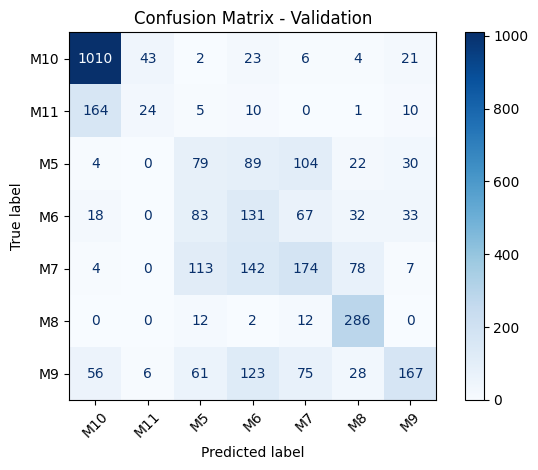

In [ ]:

# ========================
# 6) 在验证集评估（检查过拟合）
# ========================
# yhat_va = best_model.predict(X_va)
# print("VAL Acc: %.3f | Macro-F1: %.3f | BalAcc: %.3f" % (
#     accuracy_score(y_va, yhat_va),
#     f1_score(y_va, yhat_va, average="macro"),
#     balanced_accuracy_score(y_va, yhat_va)
# ))
# print("\nValidation report:\n", classification_report(y_va, yhat_va))

# labels_va = np.unique(np.concatenate([y_tr, y_va]))
# cm_va = confusion_matrix(y_va, yhat_va, labels=labels_va)
# ConfusionMatrixDisplay(cm_va, display_labels=labels_va).plot(xticks_rotation=45, cmap="Blues", values_format="d")
# plt.title("Confusion Matrix - Validation"); plt.tight_layout(); plt.show()

yhat_va = best_model.predict(X_va)

labels_va = best_model.named_steps["clf"].classes_  # 模型训练得到的类别顺序
print("VAL Acc: %.3f | Macro-F1: %.3f | BalAcc: %.3f" % (
    accuracy_score(y_va, yhat_va),
    f1_score(y_va, yhat_va, average="macro"),
    balanced_accuracy_score(y_va, yhat_va)
))

print("\nValidation report:\n", classification_report(y_va, yhat_va, labels=labels_va, target_names=labels_va))

cm_va = confusion_matrix(y_va, yhat_va, labels=labels_va)
ConfusionMatrixDisplay(cm_va, display_labels=labels_va).plot(xticks_rotation=45, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Validation"); plt.tight_layout(); plt.show()



-------

# 集成调用 val 和 test 的两版（counts，normalized）混淆矩阵

In [ ]:
## 集成 - 调用 validation 和 test 两版 的confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusions(y_true, y_pred, labels, title_prefix="Validation"):
    # 1) 计数版
    cm_counts = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(cm_counts, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix — {title_prefix} (Counts)")
    plt.tight_layout()
    plt.show()

    # 2) 归一化版（按真实标签行归一化，等价于各类召回）
    cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
    disp = ConfusionMatrixDisplay(cm_norm, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Blues", values_format=".2f")
    plt.title(f"Confusion Matrix — {title_prefix} (Recall-Normalized)")
    plt.tight_layout()
    plt.show()


## validation set的两版confusion matrix
labels_va = best_model.named_steps["clf"].classes_  # 用模型里的类顺序更稳
plot_confusions(y_va, yhat_va, labels_va, title_prefix="Validation")



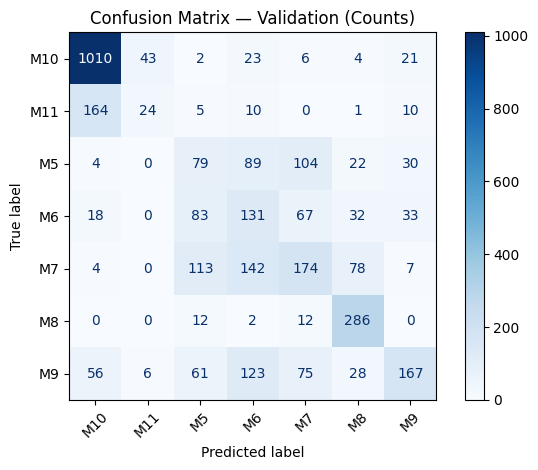

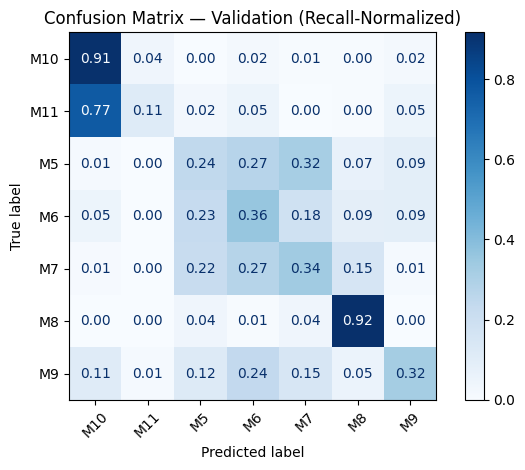

In [ ]:
## validation set的两版confusion matrix
labels_va = best_model.named_steps["clf"].classes_  # 用模型里的类顺序更稳
plot_confusions(y_va, yhat_va, labels_va, title_prefix="Validation")


---------

# 最终测试集 Test Set

In [ ]:

# ========================
# 7) Dev(Train+Val) 重训 → Test 评估（最终汇报）
# ========================
dev_mask = np.isin(groups, np.r_[train_subjects, val_subjects])
X_dev, y_dev = X[dev_mask], y[dev_mask]

# final_model = clone(best_model)
# final_model.fit(X_dev, y_dev)

# yhat_te = final_model.predict(X_te)
# print("TEST Acc: %.3f | Macro-F1: %.3f | BalAcc: %.3f" % (
#     accuracy_score(y_te, yhat_te),
#     f1_score(y_te, yhat_te, average="macro"),
#     balanced_accuracy_score(y_te, yhat_te)
# ))

# labels_te = np.unique(y_dev)
# cm_te = confusion_matrix(y_te, yhat_te, labels=labels_te)
# ConfusionMatrixDisplay(cm_te, display_labels=labels_te).plot(xticks_rotation=45, cmap="Blues", values_format="d")
# plt.title("Confusion Matrix - Test"); plt.tight_layout(); plt.show()


final_model = clone(best_model)   # 会保留所有最优超参数（含增广器里的参数）
final_model.fit(X_dev, y_dev)     # 训练阶段会在 Dev 上执行过采样+增广

yhat_te = final_model.predict(X_te)

labels_te = final_model.named_steps["clf"].classes_
print("TEST Acc: %.3f | Macro-F1: %.3f | BalAcc: %.3f" % (
    accuracy_score(y_te, yhat_te),
    f1_score(y_te, yhat_te, average="macro"),
    balanced_accuracy_score(y_te, yhat_te)
))

print("\nTest report:\n", classification_report(y_te, yhat_te, labels=labels_te, target_names=labels_te))

cm_te = confusion_matrix(y_te, yhat_te, labels=labels_te)
ConfusionMatrixDisplay(cm_te, display_labels=labels_te).plot(xticks_rotation=45, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Test"); plt.tight_layout(); plt.show()


################

## test 集的两版 confusion matrix
labels_te = final_model.named_steps["clf"].classes_
plot_confusions(y_te, yhat_te, labels_te, title_prefix="Test")


# 集成调用 val 和 test 的两版（counts，normalized）混淆矩阵

In [ ]:
## test 集的两版 confusion matrix
labels_te = final_model.named_steps["clf"].classes_
plot_confusions(y_te, yhat_te, labels_te, title_prefix="Test")


---------

-------

----

----

----

----

----

----

---

----

# 【2】HistGradientBoosting + SelectKBest

In [ ]:
# ========================
# Imports
# ========================
import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy import interpolate

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, balanced_accuracy_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.base import SamplerMixin

import matplotlib.pyplot as plt


# 可选：TSFEL
import tsfel
_cfg = tsfel.get_features_by_domain()
TSFEL_CFG = {"temporal": _cfg["temporal"], "spectral": _cfg["spectral"]}

SEED = 42
rng_global = np.random.default_rng(SEED)

# ========================
# 1) 基础工具：特征函数（TSFEL + 4 自定义）
# ========================
def _spectral_centroid_and_edge(x, fs_hz, edge_percent=0.9):
    f, Pxx = welch(x, fs=fs_hz, nperseg=min(len(x), 256))
    Pxx = np.clip(Pxx, 1e-12, None)
    sc = float(np.sum(f * Pxx) / np.sum(Pxx))
    cumsum = np.cumsum(Pxx) / np.sum(Pxx)
    idx = int(np.searchsorted(cumsum, edge_percent))
    idx = min(idx, len(f)-1)
    sef = float(f[idx])
    return sc, sef

def _jerk_stats(x, fs_hz):
    j = np.diff(x) * fs_hz
    if j.size == 0:
        return 0.0, 0.0
    jm = float(np.mean(j))
    js = float(np.std(j, ddof=1)) if j.size > 1 else 0.0
    return jm, js

def _coef_var(x):
    m = float(np.mean(x))
    if abs(m) < 1e-8:
        return 0.0
    return float(np.std(x, ddof=1) / abs(m))

def featurize_windows_tsfel_plus(X, colnames, fs_hz):
    rows = []
    for n in range(X.shape[0]):
        w = X[n]                       # (T, D)
        df_w = pd.DataFrame(w, columns=colnames)

        # TSFEL（整窗）
        tsfel_df = tsfel.time_series_features_extractor(
            TSFEL_CFG, df_w, fs=fs_hz, window_size=None, verbose=0
        )
        tsfel_df.reset_index(drop=True, inplace=True)

        # +4 自定义特征
        extras = {}
        for d, name in enumerate(colnames):
            x = w[:, d]
            sc, sef = _spectral_centroid_and_edge(x, fs_hz, edge_percent=0.90)
            if name.startswith("Acc_") or name.startswith("FreeAcc_"):
                jm, js = _jerk_stats(x, fs_hz)
            else:
                jm, js = 0.0, 0.0
            cv = _coef_var(x)
            extras[f"{name}_spec_centroid"] = sc
            extras[f"{name}_spec_edge90"]   = sef
            extras[f"{name}_jerk_mean"]     = jm
            extras[f"{name}_jerk_std"]      = js
            extras[f"{name}_coef_var"]      = cv

        rows.append(pd.concat([tsfel_df.iloc[0], pd.Series(extras)], axis=0))

    return pd.DataFrame(rows)

# ========================
# 2) 增广模块（Kulic/Um 风格）
# ========================
def _find_triplets(colnames):
    idx = {c:i for i,c in enumerate(colnames)}
    out = []
    for a,b,c in [("Acc_X","Acc_Y","Acc_Z"),
                  ("Gyr_X","Gyr_Y","Gyr_Z"),
                  ("FreeAcc_E","FreeAcc_N","FreeAcc_U")]:
        if a in idx and b in idx and c in idx:
            out.append((idx[a], idx[b], idx[c]))
    return out

def _random_rotation_matrix(rng, max_deg=20):
    theta = np.deg2rad(rng.uniform(-max_deg, max_deg))
    axis = rng.normal(size=3); axis /= (np.linalg.norm(axis)+1e-8)
    x,y,z = axis; c,s = np.cos(theta), np.sin(theta)
    return np.array([[c+x*x*(1-c),   x*y*(1-c)-z*s, x*z*(1-c)+y*s],
                     [y*x*(1-c)+z*s, c+y*y*(1-c),   y*z*(1-c)-x*s],
                     [z*x*(1-c)-y*s, z*y*(1-c)+x*s, c+z*z*(1-c)]], dtype=float)

def aug_rotate(win, triplets, rng, max_deg=20):
    if not triplets: return win
    R = _random_rotation_matrix(rng, max_deg=max_deg)
    out = win.copy()
    for i,j,k in triplets:
        out[:, [i,j,k]] = out[:, [i,j,k]] @ R.T
    return out

def aug_permute(win, rng, min_seg=3, max_seg=5):
    T = win.shape[0]
    K = rng.integers(min_seg, max_seg+1)
    idx = np.linspace(0, T, K+1).astype(int)
    segs = [win[idx[i]:idx[i+1]] for i in range(K)]
    return np.concatenate([segs[o] for o in rng.permutation(K)], axis=0)

def aug_timewarp(win, rng, sigma=0.2, knots=4):
    T, D = win.shape
    t_src = np.linspace(0, 1, T)
    knot_x = np.linspace(0, 1, knots+2)
    perturb = rng.normal(0, sigma, size=knots)
    knot_y = np.r_[0, np.cumsum(perturb)/max(1,knots), 1.0]
    knot_y = np.sort(np.clip(knot_y, 0, 1))
    spl = interpolate.UnivariateSpline(knot_x, knot_y, k=3, s=0)
    t_new = spl(t_src)
    t_new = (t_new - t_new.min()) / (t_new.max() - t_new.min() + 1e-8)
    out = np.zeros_like(win)
    for d in range(D):
        spld = interpolate.UnivariateSpline(t_src, win[:,d], k=3, s=0)
        out[:,d] = spld(t_new)
    return out

def aug_jitter(win, rng, percent=0.02):
    # 通道自适应噪声：按通道标准差的百分比
    noise = rng.normal(0, 1, size=win.shape) * (np.std(win, axis=0, ddof=1) * percent + 1e-8)
    return win + noise

def aug_scaling(win, rng, low=0.9, high=1.1):
    scale = rng.uniform(low, high, size=(1, win.shape[1]))
    return win * scale

def aug_magwarp(win, rng, sigma=0.2, knots=4):
    T, D = win.shape
    t = np.linspace(0, 1, T)
    knot_x = np.linspace(0, 1, knots+2)
    warp = np.zeros((T, D))
    for d in range(D):
        pert = rng.normal(0, sigma, size=knots)
        knot_y = np.r_[0, np.cumsum(pert)/max(1,knots), 0]
        spl = interpolate.UnivariateSpline(knot_x, knot_y, k=3, s=0)
        warp[:, d] = 1.0 + spl(t)  # around 1
    return win * warp

from sklearn.base import BaseEstimator

class WindowAugmenter(BaseEstimator):
    _parameter_constraints: dict = {}

    def __init__(self, colnames, fs_hz=40,
                 do_rot=True, rot_max_deg=20,
                 do_timewarp=False, tw_sigma=0.2, tw_knots=4,
                 do_permute=False, perm_min=3, perm_max=5,
                 do_jitter=False, jitter_pct=0.02,
                 do_scaling=False, scale_low=0.9, scale_high=1.1,
                 do_magwarp=False, mw_sigma=0.2, mw_knots=4,
                 per_class_strategy="q80",
                 random_state=42):
        self.colnames = colnames
        self.fs_hz = fs_hz
        self.do_rot = do_rot; self.rot_max_deg = rot_max_deg
        self.do_timewarp = do_timewarp; self.tw_sigma = tw_sigma; self.tw_knots = tw_knots
        self.do_permute = do_permute; self.perm_min = perm_min; self.perm_max = perm_max
        self.do_jitter = do_jitter; self.jitter_pct = jitter_pct
        self.do_scaling = do_scaling; self.scale_low = scale_low; self.scale_high = scale_high
        self.do_magwarp = do_magwarp; self.mw_sigma = mw_sigma; self.mw_knots = mw_knots
        self.per_class_strategy = per_class_strategy
        self.random_state = random_state

    def fit(self, X, y):
        self.triplets_ = _find_triplets(self.colnames)
        self.rng_ = np.random.default_rng(self.random_state)
        if (y is None) or (self.per_class_strategy == "none"):
            self.ratio_ = None
        else:
            cnt = pd.Series(y).value_counts()
            if self.per_class_strategy == "q80":
                target = int(min(cnt.max(), cnt.quantile(0.8)))
            elif self.per_class_strategy == "max":
                target = int(cnt.max())
            else:
                target = None
            self.ratio_ = None if target is None else {c: max(1, int(np.ceil(target/c))) for c in cnt.index}
        return self

    def _augment_one(self, w):
        rng = self.rng_
        out = w.copy()
        if self.do_rot:
            out = aug_rotate(out, self.triplets_, rng, max_deg=self.rot_max_deg)
        if self.do_timewarp:
            out = aug_timewarp(out, rng, sigma=self.tw_sigma, knots=self.tw_knots)
        if self.do_permute:
            out = aug_permute(out, rng, min_seg=self.perm_min, max_seg=self.perm_max)
        if self.do_jitter:
            out = aug_jitter(out, rng, percent=self.jitter_pct)
        if self.do_scaling:
            out = aug_scaling(out, rng, low=self.scale_low, high=self.scale_high)
        if self.do_magwarp:
            out = aug_magwarp(out, rng, sigma=self.mw_sigma, knots=self.mw_knots)
        return out

    def fit_resample(self, X, y):
        if getattr(self, "ratio_", None) is None:
            return X, y
        X_aug, y_aug = [X], [y]
        y_arr = np.asarray(y)
        for cls, mult in self.ratio_.items():
            if mult <= 1:
                continue
            idx = np.where(y_arr == cls)[0]
            need = (mult - 1) * len(idx)
            if need <= 0 or len(idx) == 0:
                continue
            pick = self.rng_.choice(idx, size=need, replace=True)
            aug_list = [self._augment_one(X[i]) for i in pick]
            X_aug.append(np.stack(aug_list))
            y_aug.append(np.full(len(aug_list), cls, dtype=y_arr.dtype))
        return np.concatenate(X_aug, axis=0), np.concatenate(y_aug, axis=0)

class WindowFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self, colnames, fs_hz=40):
        self.colnames = colnames; self.fs_hz = fs_hz
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Feat = featurize_windows_tsfel_plus(X, self.colnames, self.fs_hz)
        A = Feat.values    # 交给后续 StandardScaler/Selector
        A = np.nan_to_num(A, nan=0.0, posinf=0.0, neginf=0.0)  # <- 新增
        return A

####
class KBestFlex(BaseEstimator, TransformerMixin):
    _parameter_constraints: dict = {}  # 兼容 sklearn>=1.3 的参数校验

    def __init__(self, score_func=f_classif, k=200):
        """
        k: int 或 0<k<=1 的浮点比例（例如 0.6 表示保留 60% 的特征）
        """
        self.score_func = score_func
        self.k = k

    def fit(self, X, y=None):
        n = X.shape[1]
        k = self.k
        if isinstance(k, float) and 0 < k <= 1:
            k = max(1, int(round(n * k)))
        self._selector = SelectKBest(score_func=self.score_func, k=k)
        self._selector.fit(X, y)
        return self

    def transform(self, X):
        return self._selector.transform(X)

    def get_support(self, indices=False):
        return self._selector.get_support(indices=indices)

# ========================
# 3) 加载数据 & 标签合并（M10子类合并）
# ========================
data = np.load("/content/drive/My Drive/final_project/augmentation/windows/windows_5s_50pct_D9.npz")
X, y, groups = data["X"], data["y"].astype(str), data["groups"]

def collapse_walk_labels(y_arr):
    y_out = y_arr.copy().astype(str)
    mask = np.char.startswith(y_out, "M10")
    y_out[mask] = "M10"
    return y_out

y = collapse_walk_labels(y)

signal_cols = ["Acc_X","Acc_Y","Acc_Z","Gyr_X","Gyr_Y","Gyr_Z","FreeAcc_E","FreeAcc_N","FreeAcc_U"]
fs_hz = 40

# ========================
# 4) 受试者划分（示例：你可继续沿用自己的 subject 列表）
# ========================
train_subjects = np.array([29, 28, 24, 21, 3, 26, 14, 25, 12, 18, 5, 11])
val_subjects   = np.array([17, 13, 22, 23, 20])
test_subjects  = np.array([4, 2, 1, 19])

tr_mask = np.isin(groups, train_subjects)
va_mask = np.isin(groups, val_subjects)
te_mask = np.isin(groups, test_subjects)

X_tr, y_tr, g_tr = X[tr_mask], y[tr_mask], groups[tr_mask]
X_va, y_va       = X[va_mask], y[va_mask]
X_te, y_te       = X[te_mask], y[te_mask]

print("Train/Val/Test windows:", X_tr.shape, X_va.shape, X_te.shape)

# ========================
# 5) Pipeline + Grid（在 Dev=Train 上用 LOSO 调参）
# ========================
logo = LeaveOneGroupOut()

augmenter = WindowAugmenter(
    colnames=signal_cols, fs_hz=fs_hz,
    do_rot=True,  rot_max_deg=20,
    do_timewarp=True, tw_sigma=0.2, tw_knots=4,
    do_permute=False,
    do_jitter=False,
    do_scaling=False,
    do_magwarp=False,
    per_class_strategy="q80",
    random_state=42
)

pipe_hist_kbest = ImbPipeline([
    ("augment", augmenter),
    ("featurize", WindowFeaturizer(signal_cols, fs_hz)),
    ("scale", StandardScaler()),
    ("selector", KBestFlex(score_func=f_classif, k=0.6)),  # 60% 特征
    ("clf", HistGradientBoostingClassifier(random_state=SEED))
])

param_grid_hist_kbest = {
    "augment__rot_max_deg": [20],
    "augment__do_timewarp": [True],
    "augment__tw_sigma": [0.2],
    "augment__tw_knots": [4],
    "augment__per_class_strategy": ["q80"],
    "selector__k": [0.6],  # 你也可改成 [200, 400]
    "clf__learning_rate": [0.01],
    "clf__max_depth": [6],
    "clf__max_iter": [800],
    "clf__min_samples_leaf": [25],
    "clf__l2_regularization": [10.0],
    "clf__early_stopping": [True],
}

gs_hist_kbest = GridSearchCV(
    estimator=pipe_hist_kbest,
    param_grid=param_grid_hist_kbest,
    cv=logo.split(X_tr, y_tr, g_tr),  # Dev(Train) 上做 LOSO
    scoring="accuracy",
    n_jobs=2,
    verbose=2,
    refit=True
)

gs_hist_kbest.fit(X_tr, y_tr)

print("Best params:", gs_hist_kbest.best_params_)
print("Best LOSO acc on Dev(Train):", gs_hist_kbest.best_score_)

best_model_hist_kbest = gs_hist_kbest.best_estimator_

from joblib import dump
dump(best_model_hist_kbest, '/content/drive/My Drive/final_project/augmentation/modelSave/best_model_hist_kbest_0906.joblib')



Train/Val/Test windows: (7028, 200, 9) (3361, 200, 9) (2904, 200, 9)
Fitting 12 folds for each of 1 candidates, totalling 12 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [1142 1143 1147 1148 1152 1153] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params: {'augment__do_timewarp': True, 'augment__per_class_strategy': 'q80', 'augment__rot_max_deg': 20, 'augment__tw_knots': 4, 'augment__tw_sigma': 0.2, 'clf__early_stopping': True, 'clf__l2_regularization': 10.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 6, 'clf__max_iter': 800, 'clf__min_samples_leaf': 25, 'selector__k': 0.6}
Best LOSO acc on Dev(Train): 0.6108957761678777


['/content/drive/My Drive/final_project/augmentation/modelSave/best_model_hist_kbest_0906.joblib']

# 验证集+混淆矩阵

VAL Acc: 0.588 | Macro-F1: 0.495 | BalAcc: 0.501

Validation report:
               precision    recall  f1-score   support

         M10       0.81      0.92      0.86      1109
         M11       0.69      0.21      0.32       214
          M5       0.34      0.26      0.29       328
          M6       0.27      0.44      0.33       364
          M7       0.39      0.40      0.39       518
          M8       0.75      0.97      0.85       312
          M9       0.65      0.32      0.43       516

    accuracy                           0.59      3361
   macro avg       0.56      0.50      0.49      3361
weighted avg       0.60      0.59      0.57      3361



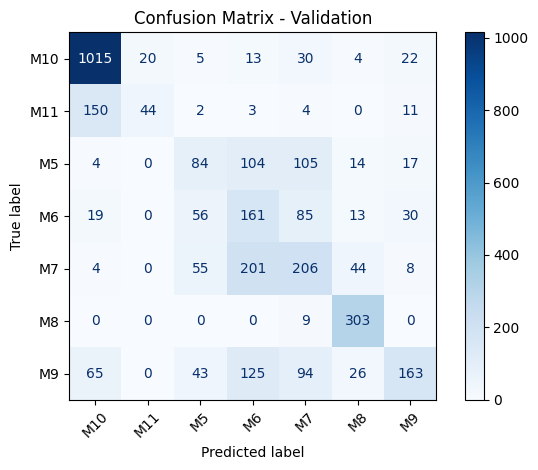

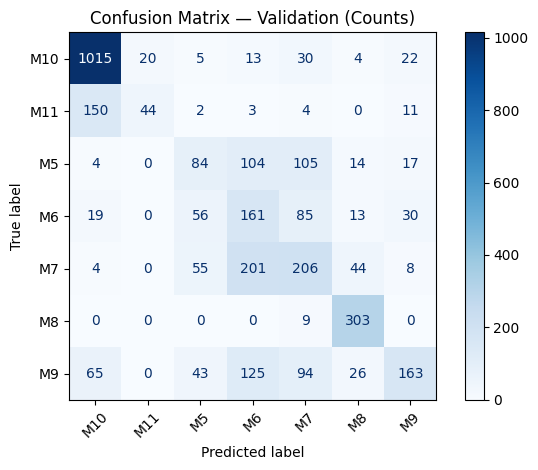

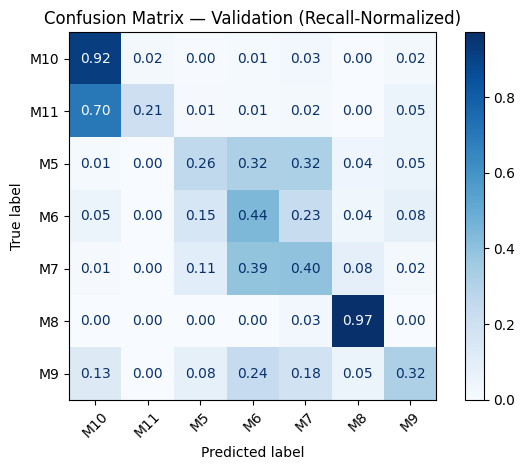

In [ ]:
# ========================
# 6) 在验证集评估（检查过拟合）
# ========================
yhat_va = best_model_hist_kbest.predict(X_va)

labels_va = best_model_hist_kbest.named_steps["clf"].classes_  # 模型训练得到的类别顺序
print("VAL Acc: %.3f | Macro-F1: %.3f | BalAcc: %.3f" % (
    accuracy_score(y_va, yhat_va),
    f1_score(y_va, yhat_va, average="macro"),
    balanced_accuracy_score(y_va, yhat_va)
))

print("\nValidation report:\n", classification_report(y_va, yhat_va, labels=labels_va, target_names=labels_va))

cm_va = confusion_matrix(y_va, yhat_va, labels=labels_va)
ConfusionMatrixDisplay(cm_va, display_labels=labels_va).plot(xticks_rotation=45, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Validation"); plt.tight_layout(); plt.show()


############################################3

## 集成 - 调用 validation 和 test 两版 的confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusions(y_true, y_pred, labels, title_prefix="Validation"):
    # 1) 计数版
    cm_counts = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(cm_counts, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix — {title_prefix} (Counts)")
    plt.tight_layout()
    plt.show()

    # 2) 归一化版（按真实标签行归一化，等价于各类召回）
    cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
    disp = ConfusionMatrixDisplay(cm_norm, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Blues", values_format=".2f")
    plt.title(f"Confusion Matrix — {title_prefix} (Recall-Normalized)")
    plt.tight_layout()
    plt.show()


## validation set的两版confusion matrix
labels_va = best_model_hist_kbest.named_steps["clf"].classes_  # 用模型里的类顺序更稳
plot_confusions(y_va, yhat_va, labels_va, title_prefix="Validation")


In [ ]:

# ========================
# 7) Dev(Train+Val) 重训 → Test 评估（最终汇报）
# ========================
dev_mask = np.isin(groups, np.r_[train_subjects, val_subjects])
X_dev, y_dev = X[dev_mask], y[dev_mask]

# final_model = clone(best_model)
# final_model.fit(X_dev, y_dev)

# yhat_te = final_model.predict(X_te)
# print("TEST Acc: %.3f | Macro-F1: %.3f | BalAcc: %.3f" % (
#     accuracy_score(y_te, yhat_te),
#     f1_score(y_te, yhat_te, average="macro"),
#     balanced_accuracy_score(y_te, yhat_te)
# ))

# labels_te = np.unique(y_dev)
# cm_te = confusion_matrix(y_te, yhat_te, labels=labels_te)
# ConfusionMatrixDisplay(cm_te, display_labels=labels_te).plot(xticks_rotation=45, cmap="Blues", values_format="d")
# plt.title("Confusion Matrix - Test"); plt.tight_layout(); plt.show()


final_model = clone(best_model)   # 会保留所有最优超参数（含增广器里的参数）
final_model.fit(X_dev, y_dev)     # 训练阶段会在 Dev 上执行过采样+增广

yhat_te = final_model.predict(X_te)

labels_te = final_model.named_steps["clf"].classes_
print("TEST Acc: %.3f | Macro-F1: %.3f | BalAcc: %.3f" % (
    accuracy_score(y_te, yhat_te),
    f1_score(y_te, yhat_te, average="macro"),
    balanced_accuracy_score(y_te, yhat_te)
))

print("\nTest report:\n", classification_report(y_te, yhat_te, labels=labels_te, target_names=labels_te))

cm_te = confusion_matrix(y_te, yhat_te, labels=labels_te)
ConfusionMatrixDisplay(cm_te, display_labels=labels_te).plot(xticks_rotation=45, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Test"); plt.tight_layout(); plt.show()


################

## test 集的两版 confusion matrix
labels_te = final_model.named_steps["clf"].classes_
plot_confusions(y_te, yhat_te, labels_te, title_prefix="Test")


----

----

----

----

----

----

----

----

----

--------

# 【3】Random Forest + SelectKBest

In [ ]:
# ========================
# Imports
# ========================
import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy import interpolate

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, balanced_accuracy_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.base import SamplerMixin


import matplotlib.pyplot as plt


# 可选：TSFEL
import tsfel
_cfg = tsfel.get_features_by_domain()
TSFEL_CFG = {"temporal": _cfg["temporal"], "spectral": _cfg["spectral"]}

SEED = 42
rng_global = np.random.default_rng(SEED)

# ========================
# 1) 基础工具：特征函数（TSFEL + 4 自定义）
# ========================
def _spectral_centroid_and_edge(x, fs_hz, edge_percent=0.9):
    f, Pxx = welch(x, fs=fs_hz, nperseg=min(len(x), 256))
    Pxx = np.clip(Pxx, 1e-12, None)
    sc = float(np.sum(f * Pxx) / np.sum(Pxx))
    cumsum = np.cumsum(Pxx) / np.sum(Pxx)
    idx = int(np.searchsorted(cumsum, edge_percent))
    idx = min(idx, len(f)-1)
    sef = float(f[idx])
    return sc, sef

def _jerk_stats(x, fs_hz):
    j = np.diff(x) * fs_hz
    if j.size == 0:
        return 0.0, 0.0
    jm = float(np.mean(j))
    js = float(np.std(j, ddof=1)) if j.size > 1 else 0.0
    return jm, js

def _coef_var(x):
    m = float(np.mean(x))
    if abs(m) < 1e-8:
        return 0.0
    return float(np.std(x, ddof=1) / abs(m))

def featurize_windows_tsfel_plus(X, colnames, fs_hz):
    rows = []
    for n in range(X.shape[0]):
        w = X[n]                       # (T, D)
        df_w = pd.DataFrame(w, columns=colnames)

        # TSFEL（整窗）
        tsfel_df = tsfel.time_series_features_extractor(
            TSFEL_CFG, df_w, fs=fs_hz, window_size=None, verbose=0
        )
        tsfel_df.reset_index(drop=True, inplace=True)

        # +4 自定义特征
        extras = {}
        for d, name in enumerate(colnames):
            x = w[:, d]
            sc, sef = _spectral_centroid_and_edge(x, fs_hz, edge_percent=0.90)
            if name.startswith("Acc_") or name.startswith("FreeAcc_"):
                jm, js = _jerk_stats(x, fs_hz)
            else:
                jm, js = 0.0, 0.0
            cv = _coef_var(x)
            extras[f"{name}_spec_centroid"] = sc
            extras[f"{name}_spec_edge90"]   = sef
            extras[f"{name}_jerk_mean"]     = jm
            extras[f"{name}_jerk_std"]      = js
            extras[f"{name}_coef_var"]      = cv

        rows.append(pd.concat([tsfel_df.iloc[0], pd.Series(extras)], axis=0))

    return pd.DataFrame(rows)

# ========================
# 2) 增广模块（Kulic/Um 风格）
# ========================
def _find_triplets(colnames):
    idx = {c:i for i,c in enumerate(colnames)}
    out = []
    for a,b,c in [("Acc_X","Acc_Y","Acc_Z"),
                  ("Gyr_X","Gyr_Y","Gyr_Z"),
                  ("FreeAcc_E","FreeAcc_N","FreeAcc_U")]:
        if a in idx and b in idx and c in idx:
            out.append((idx[a], idx[b], idx[c]))
    return out

def _random_rotation_matrix(rng, max_deg=20):
    theta = np.deg2rad(rng.uniform(-max_deg, max_deg))
    axis = rng.normal(size=3); axis /= (np.linalg.norm(axis)+1e-8)
    x,y,z = axis; c,s = np.cos(theta), np.sin(theta)
    return np.array([[c+x*x*(1-c),   x*y*(1-c)-z*s, x*z*(1-c)+y*s],
                     [y*x*(1-c)+z*s, c+y*y*(1-c),   y*z*(1-c)-x*s],
                     [z*x*(1-c)-y*s, z*y*(1-c)+x*s, c+z*z*(1-c)]], dtype=float)

def aug_rotate(win, triplets, rng, max_deg=20):
    if not triplets: return win
    R = _random_rotation_matrix(rng, max_deg=max_deg)
    out = win.copy()
    for i,j,k in triplets:
        out[:, [i,j,k]] = out[:, [i,j,k]] @ R.T
    return out

def aug_permute(win, rng, min_seg=3, max_seg=5):
    T = win.shape[0]
    K = rng.integers(min_seg, max_seg+1)
    idx = np.linspace(0, T, K+1).astype(int)
    segs = [win[idx[i]:idx[i+1]] for i in range(K)]
    return np.concatenate([segs[o] for o in rng.permutation(K)], axis=0)

def aug_timewarp(win, rng, sigma=0.2, knots=4):
    T, D = win.shape
    t_src = np.linspace(0, 1, T)
    knot_x = np.linspace(0, 1, knots+2)
    perturb = rng.normal(0, sigma, size=knots)
    knot_y = np.r_[0, np.cumsum(perturb)/max(1,knots), 1.0]
    knot_y = np.sort(np.clip(knot_y, 0, 1))
    spl = interpolate.UnivariateSpline(knot_x, knot_y, k=3, s=0)
    t_new = spl(t_src)
    t_new = (t_new - t_new.min()) / (t_new.max() - t_new.min() + 1e-8)
    out = np.zeros_like(win)
    for d in range(D):
        spld = interpolate.UnivariateSpline(t_src, win[:,d], k=3, s=0)
        out[:,d] = spld(t_new)
    return out

def aug_jitter(win, rng, percent=0.02):
    # 通道自适应噪声：按通道标准差的百分比
    noise = rng.normal(0, 1, size=win.shape) * (np.std(win, axis=0, ddof=1) * percent + 1e-8)
    return win + noise

def aug_scaling(win, rng, low=0.9, high=1.1):
    scale = rng.uniform(low, high, size=(1, win.shape[1]))
    return win * scale

def aug_magwarp(win, rng, sigma=0.2, knots=4):
    T, D = win.shape
    t = np.linspace(0, 1, T)
    knot_x = np.linspace(0, 1, knots+2)
    warp = np.zeros((T, D))
    for d in range(D):
        pert = rng.normal(0, sigma, size=knots)
        knot_y = np.r_[0, np.cumsum(pert)/max(1,knots), 0]
        spl = interpolate.UnivariateSpline(knot_x, knot_y, k=3, s=0)
        warp[:, d] = 1.0 + spl(t)  # around 1
    return win * warp

from sklearn.base import BaseEstimator

class WindowAugmenter(BaseEstimator):
    _parameter_constraints: dict = {}

    def __init__(self, colnames, fs_hz=40,
                 do_rot=True, rot_max_deg=20,
                 do_timewarp=False, tw_sigma=0.2, tw_knots=4,
                 do_permute=False, perm_min=3, perm_max=5,
                 do_jitter=False, jitter_pct=0.02,
                 do_scaling=False, scale_low=0.9, scale_high=1.1,
                 do_magwarp=False, mw_sigma=0.2, mw_knots=4,
                 per_class_strategy="q80",
                 random_state=42):
        self.colnames = colnames
        self.fs_hz = fs_hz
        self.do_rot = do_rot; self.rot_max_deg = rot_max_deg
        self.do_timewarp = do_timewarp; self.tw_sigma = tw_sigma; self.tw_knots = tw_knots
        self.do_permute = do_permute; self.perm_min = perm_min; self.perm_max = perm_max
        self.do_jitter = do_jitter; self.jitter_pct = jitter_pct
        self.do_scaling = do_scaling; self.scale_low = scale_low; self.scale_high = scale_high
        self.do_magwarp = do_magwarp; self.mw_sigma = mw_sigma; self.mw_knots = mw_knots
        self.per_class_strategy = per_class_strategy
        self.random_state = random_state

    def fit(self, X, y):
        self.triplets_ = _find_triplets(self.colnames)
        self.rng_ = np.random.default_rng(self.random_state)
        if (y is None) or (self.per_class_strategy == "none"):
            self.ratio_ = None
        else:
            cnt = pd.Series(y).value_counts()
            if self.per_class_strategy == "q80":
                target = int(min(cnt.max(), cnt.quantile(0.8)))
            elif self.per_class_strategy == "max":
                target = int(cnt.max())
            else:
                target = None
            self.ratio_ = None if target is None else {c: max(1, int(np.ceil(target/c))) for c in cnt.index}
        return self

    def _augment_one(self, w):
        rng = self.rng_
        out = w.copy()
        if self.do_rot:
            out = aug_rotate(out, self.triplets_, rng, max_deg=self.rot_max_deg)
        if self.do_timewarp:
            out = aug_timewarp(out, rng, sigma=self.tw_sigma, knots=self.tw_knots)
        if self.do_permute:
            out = aug_permute(out, rng, min_seg=self.perm_min, max_seg=self.perm_max)
        if self.do_jitter:
            out = aug_jitter(out, rng, percent=self.jitter_pct)
        if self.do_scaling:
            out = aug_scaling(out, rng, low=self.scale_low, high=self.scale_high)
        if self.do_magwarp:
            out = aug_magwarp(out, rng, sigma=self.mw_sigma, knots=self.mw_knots)
        return out

    def fit_resample(self, X, y):
        if getattr(self, "ratio_", None) is None:
            return X, y
        X_aug, y_aug = [X], [y]
        y_arr = np.asarray(y)
        for cls, mult in self.ratio_.items():
            if mult <= 1:
                continue
            idx = np.where(y_arr == cls)[0]
            need = (mult - 1) * len(idx)
            if need <= 0 or len(idx) == 0:
                continue
            pick = self.rng_.choice(idx, size=need, replace=True)
            aug_list = [self._augment_one(X[i]) for i in pick]
            X_aug.append(np.stack(aug_list))
            y_aug.append(np.full(len(aug_list), cls, dtype=y_arr.dtype))
        return np.concatenate(X_aug, axis=0), np.concatenate(y_aug, axis=0)

class WindowFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self, colnames, fs_hz=40):
        self.colnames = colnames; self.fs_hz = fs_hz
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Feat = featurize_windows_tsfel_plus(X, self.colnames, self.fs_hz)
        A = Feat.values    # 交给后续 StandardScaler/Selector
        A = np.nan_to_num(A, nan=0.0, posinf=0.0, neginf=0.0)  # <- 新增
        return A


####
class KBestFlex(BaseEstimator, TransformerMixin):
    _parameter_constraints: dict = {}  # 兼容 sklearn>=1.3 的参数校验

    def __init__(self, score_func=f_classif, k=200):
        """
        k: int 或 0<k<=1 的浮点比例（例如 0.6 表示保留 60% 的特征）
        """
        self.score_func = score_func
        self.k = k

    def fit(self, X, y=None):
        n = X.shape[1]
        k = self.k
        if isinstance(k, float) and 0 < k <= 1:
            k = max(1, int(round(n * k)))
        self._selector = SelectKBest(score_func=self.score_func, k=k)
        self._selector.fit(X, y)
        return self

    def transform(self, X):
        return self._selector.transform(X)

    def get_support(self, indices=False):
        return self._selector.get_support(indices=indices)

# ========================
# 3) 加载数据 & 标签合并（M10子类合并）
# ========================
data = np.load("/content/drive/My Drive/final_project/augmentation/windows/windows_5s_50pct_D9.npz")
X, y, groups = data["X"], data["y"].astype(str), data["groups"]

def collapse_walk_labels(y_arr):
    y_out = y_arr.copy().astype(str)
    mask = np.char.startswith(y_out, "M10")
    y_out[mask] = "M10"
    return y_out

y = collapse_walk_labels(y)

signal_cols = ["Acc_X","Acc_Y","Acc_Z","Gyr_X","Gyr_Y","Gyr_Z","FreeAcc_E","FreeAcc_N","FreeAcc_U"]
fs_hz = 40

# ========================
# 4) 受试者划分（示例：你可继续沿用自己的 subject 列表）
# ========================
train_subjects = np.array([29, 28, 24, 21, 3, 26, 14, 25, 12, 18, 5, 11])
val_subjects   = np.array([17, 13, 22, 23, 20])
test_subjects  = np.array([4, 2, 1, 19])

tr_mask = np.isin(groups, train_subjects)
va_mask = np.isin(groups, val_subjects)
te_mask = np.isin(groups, test_subjects)

X_tr, y_tr, g_tr = X[tr_mask], y[tr_mask], groups[tr_mask]
X_va, y_va       = X[va_mask], y[va_mask]
X_te, y_te       = X[te_mask], y[te_mask]

print("Train/Val/Test windows:", X_tr.shape, X_va.shape, X_te.shape)

# ========================
# 5) Pipeline + Grid（在 Dev=Train 上用 LOSO 调参）
# ========================
logo = LeaveOneGroupOut()

augmenter = WindowAugmenter(
    colnames=signal_cols, fs_hz=fs_hz,
    do_rot=True,  rot_max_deg=20,
    do_timewarp=True, tw_sigma=0.2, tw_knots=4,
    do_permute=False,
    do_jitter=False,
    do_scaling=False,
    do_magwarp=False,
    per_class_strategy="q80",
    random_state=42
)

pipe_rf_kbest = ImbPipeline([
    ("augment", augmenter),
    ("featurize", WindowFeaturizer(signal_cols, fs_hz)),
    ("scale", StandardScaler()),
    ("selector", KBestFlex(score_func=f_classif, k=0.6)),  # 或整数
    ("clf", RandomForestClassifier(
        class_weight="balanced_subsample",  # 与我们的过采样叠加时更稳
        n_jobs=-1, random_state=SEED
    ))
])

param_grid_rf_kbest = {
    "augment__rot_max_deg": [20],
    "augment__do_timewarp": [True],
    "augment__tw_sigma": [0.2],
    "augment__tw_knots": [4],
    "augment__per_class_strategy": ["q80"],
    "selector__k": [0.6],
    "clf__n_estimators": [600],        # 你也可试 [300, 600]
    "clf__max_depth": [10],      # None 表示不限制
    "clf__min_samples_split": [4],   # [2, 4]
    "clf__min_samples_leaf": [8],    # [2, 8]
    "clf__max_features": ["sqrt"],     # 或 0.5
}

gs_rf_kbest = GridSearchCV(
    estimator=pipe_rf_kbest,
    param_grid=param_grid_rf_kbest,
    cv=logo.split(X_tr, y_tr, g_tr),
    scoring="accuracy",
    n_jobs=2,
    verbose=2,
    refit=True
)

gs_rf_kbest.fit(X_tr, y_tr)


print("Best params:", gs_rf_kbest.best_params_)
print("Best LOSO acc on Dev(Train):", gs_rf_kbest.best_score_)

best_model_rf_kbest = gs_rf_kbest.best_estimator_

from joblib import dump
dump(best_model_rf_kbest, '/content/drive/My Drive/final_project/augmentation/modelSave/best_model_rf_KBest_0906.joblib')



Train/Val/Test windows: (7028, 200, 9) (3361, 200, 9) (2904, 200, 9)
Fitting 12 folds for each of 1 candidates, totalling 12 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [1142 1143 1147 1148 1152 1153] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params: {'augment__do_timewarp': True, 'augment__per_class_strategy': 'q80', 'augment__rot_max_deg': 20, 'augment__tw_knots': 4, 'augment__tw_sigma': 0.2, 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 8, 'clf__min_samples_split': 4, 'clf__n_estimators': 600, 'selector__k': 0.6}
Best LOSO acc on Dev(Train): 0.5615171239872317


['/content/drive/My Drive/final_project/augmentation/modelSave/best_model_rf_KBest_0906.joblib']

# 验证集+混淆矩阵

VAL Acc: 0.548 | Macro-F1: 0.473 | BalAcc: 0.479

Validation report:
               precision    recall  f1-score   support

         M10       0.82      0.83      0.83      1109
         M11       0.50      0.24      0.33       214
          M5       0.28      0.30      0.29       328
          M6       0.25      0.41      0.31       364
          M7       0.35      0.32      0.33       518
          M8       0.77      0.95      0.85       312
          M9       0.51      0.29      0.37       516

    accuracy                           0.55      3361
   macro avg       0.50      0.48      0.47      3361
weighted avg       0.56      0.55      0.54      3361



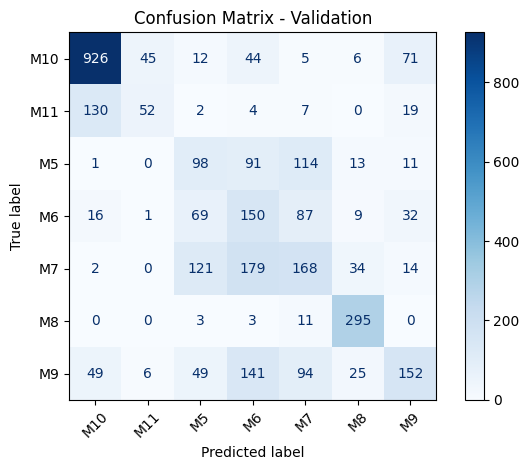

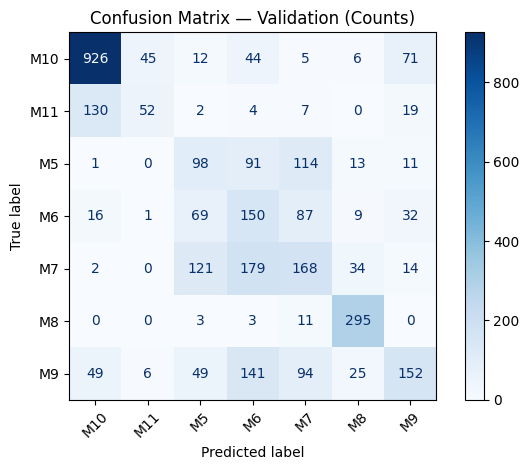

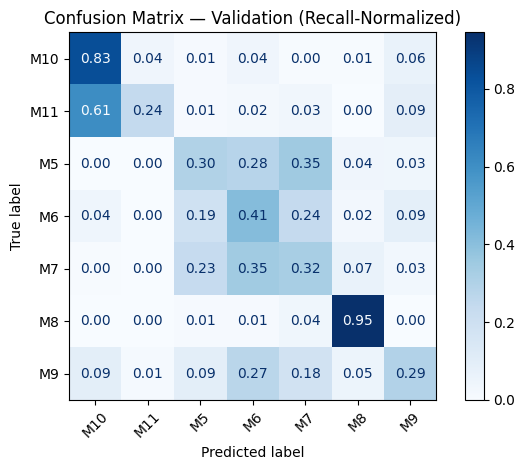

In [ ]:
# ========================
# 6) 在验证集评估（检查过拟合）
# ========================
yhat_va = best_model_rf_kbest.predict(X_va)

labels_va = best_model_rf_kbest.named_steps["clf"].classes_  # 模型训练得到的类别顺序
print("VAL Acc: %.3f | Macro-F1: %.3f | BalAcc: %.3f" % (
    accuracy_score(y_va, yhat_va),
    f1_score(y_va, yhat_va, average="macro"),
    balanced_accuracy_score(y_va, yhat_va)
))

print("\nValidation report:\n", classification_report(y_va, yhat_va, labels=labels_va, target_names=labels_va))

cm_va = confusion_matrix(y_va, yhat_va, labels=labels_va)
ConfusionMatrixDisplay(cm_va, display_labels=labels_va).plot(xticks_rotation=45, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Validation"); plt.tight_layout(); plt.show()


############################################3

## 集成 - 调用 validation 和 test 两版 的confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusions(y_true, y_pred, labels, title_prefix="Validation"):
    # 1) 计数版
    cm_counts = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(cm_counts, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix — {title_prefix} (Counts)")
    plt.tight_layout()
    plt.show()

    # 2) 归一化版（按真实标签行归一化，等价于各类召回）
    cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
    disp = ConfusionMatrixDisplay(cm_norm, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Blues", values_format=".2f")
    plt.title(f"Confusion Matrix — {title_prefix} (Recall-Normalized)")
    plt.tight_layout()
    plt.show()


## validation set的两版confusion matrix
labels_va = best_model_rf_kbest.named_steps["clf"].classes_  # 用模型里的类顺序更稳
plot_confusions(y_va, yhat_va, labels_va, title_prefix="Validation")




----

-----

----

----

----

----

----

----

----

----

# 【4】LightGBM + PCA

In [ ]:
# ========================
# Imports
# ========================
import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy import interpolate

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, balanced_accuracy_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.base import SamplerMixin
from lightgbm import LGBMClassifier


import matplotlib.pyplot as plt


# 可选：TSFEL
import tsfel
_cfg = tsfel.get_features_by_domain()
TSFEL_CFG = {"temporal": _cfg["temporal"], "spectral": _cfg["spectral"]}

SEED = 42
rng_global = np.random.default_rng(SEED)

# ========================
# 1) 基础工具：特征函数（TSFEL + 4 自定义）
# ========================
def _spectral_centroid_and_edge(x, fs_hz, edge_percent=0.9):
    f, Pxx = welch(x, fs=fs_hz, nperseg=min(len(x), 256))
    Pxx = np.clip(Pxx, 1e-12, None)
    sc = float(np.sum(f * Pxx) / np.sum(Pxx))
    cumsum = np.cumsum(Pxx) / np.sum(Pxx)
    idx = int(np.searchsorted(cumsum, edge_percent))
    idx = min(idx, len(f)-1)
    sef = float(f[idx])
    return sc, sef

def _jerk_stats(x, fs_hz):
    j = np.diff(x) * fs_hz
    if j.size == 0:
        return 0.0, 0.0
    jm = float(np.mean(j))
    js = float(np.std(j, ddof=1)) if j.size > 1 else 0.0
    return jm, js

def _coef_var(x):
    m = float(np.mean(x))
    if abs(m) < 1e-8:
        return 0.0
    return float(np.std(x, ddof=1) / abs(m))

def featurize_windows_tsfel_plus(X, colnames, fs_hz):
    rows = []
    for n in range(X.shape[0]):
        w = X[n]                       # (T, D)
        df_w = pd.DataFrame(w, columns=colnames)

        # TSFEL（整窗）
        tsfel_df = tsfel.time_series_features_extractor(
            TSFEL_CFG, df_w, fs=fs_hz, window_size=None, verbose=0
        )
        tsfel_df.reset_index(drop=True, inplace=True)

        # +4 自定义特征
        extras = {}
        for d, name in enumerate(colnames):
            x = w[:, d]
            sc, sef = _spectral_centroid_and_edge(x, fs_hz, edge_percent=0.90)
            if name.startswith("Acc_") or name.startswith("FreeAcc_"):
                jm, js = _jerk_stats(x, fs_hz)
            else:
                jm, js = 0.0, 0.0
            cv = _coef_var(x)
            extras[f"{name}_spec_centroid"] = sc
            extras[f"{name}_spec_edge90"]   = sef
            extras[f"{name}_jerk_mean"]     = jm
            extras[f"{name}_jerk_std"]      = js
            extras[f"{name}_coef_var"]      = cv

        rows.append(pd.concat([tsfel_df.iloc[0], pd.Series(extras)], axis=0))

    return pd.DataFrame(rows)

# ========================
# 2) 增广模块（Kulic/Um 风格）
# ========================
def _find_triplets(colnames):
    idx = {c:i for i,c in enumerate(colnames)}
    out = []
    for a,b,c in [("Acc_X","Acc_Y","Acc_Z"),
                  ("Gyr_X","Gyr_Y","Gyr_Z"),
                  ("FreeAcc_E","FreeAcc_N","FreeAcc_U")]:
        if a in idx and b in idx and c in idx:
            out.append((idx[a], idx[b], idx[c]))
    return out

def _random_rotation_matrix(rng, max_deg=20):
    theta = np.deg2rad(rng.uniform(-max_deg, max_deg))
    axis = rng.normal(size=3); axis /= (np.linalg.norm(axis)+1e-8)
    x,y,z = axis; c,s = np.cos(theta), np.sin(theta)
    return np.array([[c+x*x*(1-c),   x*y*(1-c)-z*s, x*z*(1-c)+y*s],
                     [y*x*(1-c)+z*s, c+y*y*(1-c),   y*z*(1-c)-x*s],
                     [z*x*(1-c)-y*s, z*y*(1-c)+x*s, c+z*z*(1-c)]], dtype=float)

def aug_rotate(win, triplets, rng, max_deg=20):
    if not triplets: return win
    R = _random_rotation_matrix(rng, max_deg=max_deg)
    out = win.copy()
    for i,j,k in triplets:
        out[:, [i,j,k]] = out[:, [i,j,k]] @ R.T
    return out

def aug_permute(win, rng, min_seg=3, max_seg=5):
    T = win.shape[0]
    K = rng.integers(min_seg, max_seg+1)
    idx = np.linspace(0, T, K+1).astype(int)
    segs = [win[idx[i]:idx[i+1]] for i in range(K)]
    return np.concatenate([segs[o] for o in rng.permutation(K)], axis=0)

def aug_timewarp(win, rng, sigma=0.2, knots=4):
    T, D = win.shape
    t_src = np.linspace(0, 1, T)
    knot_x = np.linspace(0, 1, knots+2)
    perturb = rng.normal(0, sigma, size=knots)
    knot_y = np.r_[0, np.cumsum(perturb)/max(1,knots), 1.0]
    knot_y = np.sort(np.clip(knot_y, 0, 1))
    spl = interpolate.UnivariateSpline(knot_x, knot_y, k=3, s=0)
    t_new = spl(t_src)
    t_new = (t_new - t_new.min()) / (t_new.max() - t_new.min() + 1e-8)
    out = np.zeros_like(win)
    for d in range(D):
        spld = interpolate.UnivariateSpline(t_src, win[:,d], k=3, s=0)
        out[:,d] = spld(t_new)
    return out

def aug_jitter(win, rng, percent=0.02):
    # 通道自适应噪声：按通道标准差的百分比
    noise = rng.normal(0, 1, size=win.shape) * (np.std(win, axis=0, ddof=1) * percent + 1e-8)
    return win + noise

def aug_scaling(win, rng, low=0.9, high=1.1):
    scale = rng.uniform(low, high, size=(1, win.shape[1]))
    return win * scale

def aug_magwarp(win, rng, sigma=0.2, knots=4):
    T, D = win.shape
    t = np.linspace(0, 1, T)
    knot_x = np.linspace(0, 1, knots+2)
    warp = np.zeros((T, D))
    for d in range(D):
        pert = rng.normal(0, sigma, size=knots)
        knot_y = np.r_[0, np.cumsum(pert)/max(1,knots), 0]
        spl = interpolate.UnivariateSpline(knot_x, knot_y, k=3, s=0)
        warp[:, d] = 1.0 + spl(t)  # around 1
    return win * warp

from sklearn.base import BaseEstimator

class WindowAugmenter(BaseEstimator):
    _parameter_constraints: dict = {}

    def __init__(self, colnames, fs_hz=40,
                 do_rot=True, rot_max_deg=20,
                 do_timewarp=False, tw_sigma=0.2, tw_knots=4,
                 do_permute=False, perm_min=3, perm_max=5,
                 do_jitter=False, jitter_pct=0.02,
                 do_scaling=False, scale_low=0.9, scale_high=1.1,
                 do_magwarp=False, mw_sigma=0.2, mw_knots=4,
                 per_class_strategy="q80",
                 random_state=42):
        self.colnames = colnames
        self.fs_hz = fs_hz
        self.do_rot = do_rot; self.rot_max_deg = rot_max_deg
        self.do_timewarp = do_timewarp; self.tw_sigma = tw_sigma; self.tw_knots = tw_knots
        self.do_permute = do_permute; self.perm_min = perm_min; self.perm_max = perm_max
        self.do_jitter = do_jitter; self.jitter_pct = jitter_pct
        self.do_scaling = do_scaling; self.scale_low = scale_low; self.scale_high = scale_high
        self.do_magwarp = do_magwarp; self.mw_sigma = mw_sigma; self.mw_knots = mw_knots
        self.per_class_strategy = per_class_strategy
        self.random_state = random_state

    def fit(self, X, y):
        self.triplets_ = _find_triplets(self.colnames)
        self.rng_ = np.random.default_rng(self.random_state)
        if (y is None) or (self.per_class_strategy == "none"):
            self.ratio_ = None
        else:
            cnt = pd.Series(y).value_counts()
            if self.per_class_strategy == "q80":
                target = int(min(cnt.max(), cnt.quantile(0.8)))
            elif self.per_class_strategy == "max":
                target = int(cnt.max())
            else:
                target = None
            self.ratio_ = None if target is None else {c: max(1, int(np.ceil(target/c))) for c in cnt.index}
        return self

    def _augment_one(self, w):
        rng = self.rng_
        out = w.copy()
        if self.do_rot:
            out = aug_rotate(out, self.triplets_, rng, max_deg=self.rot_max_deg)
        if self.do_timewarp:
            out = aug_timewarp(out, rng, sigma=self.tw_sigma, knots=self.tw_knots)
        if self.do_permute:
            out = aug_permute(out, rng, min_seg=self.perm_min, max_seg=self.perm_max)
        if self.do_jitter:
            out = aug_jitter(out, rng, percent=self.jitter_pct)
        if self.do_scaling:
            out = aug_scaling(out, rng, low=self.scale_low, high=self.scale_high)
        if self.do_magwarp:
            out = aug_magwarp(out, rng, sigma=self.mw_sigma, knots=self.mw_knots)
        return out

    def fit_resample(self, X, y):
        if getattr(self, "ratio_", None) is None:
            return X, y
        X_aug, y_aug = [X], [y]
        y_arr = np.asarray(y)
        for cls, mult in self.ratio_.items():
            if mult <= 1:
                continue
            idx = np.where(y_arr == cls)[0]
            need = (mult - 1) * len(idx)
            if need <= 0 or len(idx) == 0:
                continue
            pick = self.rng_.choice(idx, size=need, replace=True)
            aug_list = [self._augment_one(X[i]) for i in pick]
            X_aug.append(np.stack(aug_list))
            y_aug.append(np.full(len(aug_list), cls, dtype=y_arr.dtype))
        return np.concatenate(X_aug, axis=0), np.concatenate(y_aug, axis=0)

class WindowFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self, colnames, fs_hz=40):
        self.colnames = colnames; self.fs_hz = fs_hz
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Feat = featurize_windows_tsfel_plus(X, self.colnames, self.fs_hz)
        A = Feat.values    # 交给后续 StandardScaler/Selector
        A = np.nan_to_num(A, nan=0.0, posinf=0.0, neginf=0.0)  # <- 新增
        return A

# ========================
# 3) 加载数据 & 标签合并（M10子类合并）
# ========================
data = np.load("/content/drive/My Drive/final_project/augmentation/windows/windows_5s_50pct_D9.npz")
X, y, groups = data["X"], data["y"].astype(str), data["groups"]

def collapse_walk_labels(y_arr):
    y_out = y_arr.copy().astype(str)
    mask = np.char.startswith(y_out, "M10")
    y_out[mask] = "M10"
    return y_out

y = collapse_walk_labels(y)

signal_cols = ["Acc_X","Acc_Y","Acc_Z","Gyr_X","Gyr_Y","Gyr_Z","FreeAcc_E","FreeAcc_N","FreeAcc_U"]
fs_hz = 40

# ========================
# 4) 受试者划分（示例：你可继续沿用自己的 subject 列表）
# ========================
train_subjects = np.array([29, 28, 24, 21, 3, 26, 14, 25, 12, 18, 5, 11])
val_subjects   = np.array([17, 13, 22, 23, 20])
test_subjects  = np.array([4, 2, 1, 19])

tr_mask = np.isin(groups, train_subjects)
va_mask = np.isin(groups, val_subjects)
te_mask = np.isin(groups, test_subjects)

X_tr, y_tr, g_tr = X[tr_mask], y[tr_mask], groups[tr_mask]
X_va, y_va       = X[va_mask], y[va_mask]
X_te, y_te       = X[te_mask], y[te_mask]

print("Train/Val/Test windows:", X_tr.shape, X_va.shape, X_te.shape)

# ========================
# 5) Pipeline + Grid（在 Dev=Train 上用 LOSO 调参）
# ========================
logo = LeaveOneGroupOut()

augmenter = WindowAugmenter(
    colnames=signal_cols, fs_hz=fs_hz,
    do_rot=True,  rot_max_deg=20,
    do_timewarp=True, tw_sigma=0.2, tw_knots=4,
    do_permute=False,
    do_jitter=False,
    do_scaling=False,
    do_magwarp=False,
    per_class_strategy="q80",
    random_state=42
)

pipe_lgbm_pca = ImbPipeline([
    ("augment", augmenter),
    ("featurize", WindowFeaturizer(signal_cols, fs_hz)),
    ("scale", StandardScaler()),
    ("selector", PCA(random_state=SEED)),
    ("clf", LGBMClassifier(
        objective="multiclass", num_class=len(np.unique(y_tr)),
        random_state=SEED, n_jobs=-1
    ))
])

param_grid_lgbm_pca = {
    "augment__per_class_strategy": ["q80"],
    "selector__n_components": [0.8],
    "clf__learning_rate": [0.05],          # 0.01,
    "clf__n_estimators": [800],         # 600,
    "clf__max_depth": [8],          # -1 表示不限制, -1, 6,
    "clf__num_leaves": [63],           # 31,
    "clf__min_child_samples": [100],       # 50,
    "clf__subsample": [1.0],          # bagging  # 0.7,
    "clf__colsample_bytree": [1.0],       # 0.7,
    "clf__reg_lambda": [10.0],             # 0.0,
}

gs_lgbm_pca = GridSearchCV(
    estimator=pipe_lgbm_pca,
    param_grid=param_grid_lgbm_pca,
    cv=logo.split(X_tr, y_tr, g_tr),
    scoring="accuracy",
    n_jobs=2,
    verbose=2,
    refit=True
)

gs_lgbm_pca.fit(X_tr, y_tr)

print("Best params:", gs_lgbm_pca.best_params_)
print("Best LOSO acc on Dev(Train):", gs_lgbm_pca.best_score_)

best_model_lgbm_pca = gs_lgbm_pca.best_estimator_

from joblib import dump
dump(best_model_lgbm_pca, '/content/drive/My Drive/final_project/augmentation/modelSave/best_model_lgbm_pca_0906.joblib')



Train/Val/Test windows: (7028, 200, 9) (3361, 200, 9) (2904, 200, 9)
Fitting 12 folds for each of 1 candidates, totalling 12 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


流式输出内容被截断，只能显示最后 5000 行内容。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

['/content/drive/My Drive/final_project/augmentation/modelSave/best_model_lgbm_pca_0906.joblib']

# 验证集+混淆矩阵

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


VAL Acc: 0.565 | Macro-F1: 0.460 | BalAcc: 0.476

Validation report:
               precision    recall  f1-score   support

         M10       0.81      0.89      0.85      1109
         M11       0.30      0.15      0.20       214
          M5       0.24      0.28      0.26       328
          M6       0.27      0.35      0.30       364
          M7       0.42      0.34      0.37       518
          M8       0.65      0.96      0.78       312
          M9       0.62      0.36      0.46       516

    accuracy                           0.57      3361
   macro avg       0.47      0.48      0.46      3361
weighted avg       0.56      0.57      0.55      3361



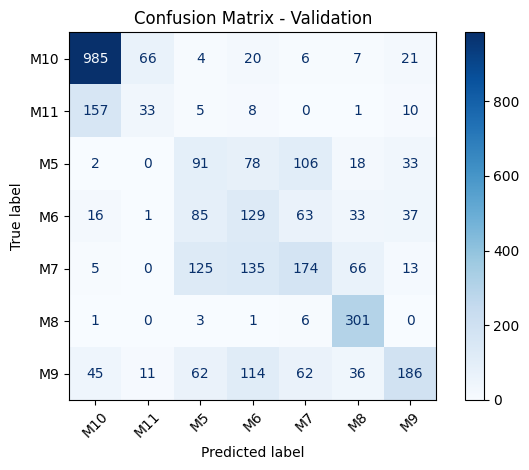

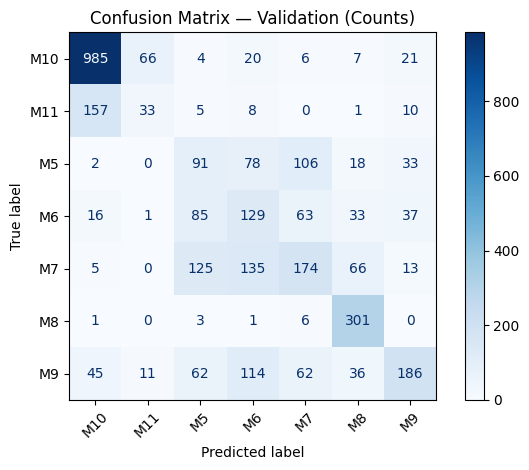

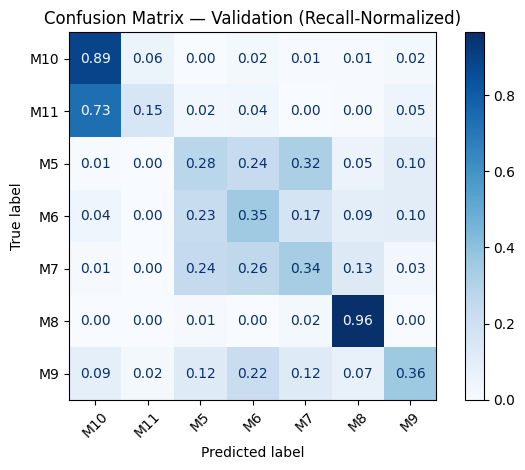

In [ ]:
# ========================
# 6) 在验证集评估（检查过拟合）
# ========================
yhat_va = best_model_lgbm_pca.predict(X_va)

labels_va = best_model_lgbm_pca.named_steps["clf"].classes_  # 模型训练得到的类别顺序
print("VAL Acc: %.3f | Macro-F1: %.3f | BalAcc: %.3f" % (
    accuracy_score(y_va, yhat_va),
    f1_score(y_va, yhat_va, average="macro"),
    balanced_accuracy_score(y_va, yhat_va)
))

print("\nValidation report:\n", classification_report(y_va, yhat_va, labels=labels_va, target_names=labels_va))

cm_va = confusion_matrix(y_va, yhat_va, labels=labels_va)
ConfusionMatrixDisplay(cm_va, display_labels=labels_va).plot(xticks_rotation=45, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Validation"); plt.tight_layout(); plt.show()


############################################3

## 集成 - 调用 validation 和 test 两版 的confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusions(y_true, y_pred, labels, title_prefix="Validation"):
    # 1) 计数版
    cm_counts = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(cm_counts, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix — {title_prefix} (Counts)")
    plt.tight_layout()
    plt.show()

    # 2) 归一化版（按真实标签行归一化，等价于各类召回）
    cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
    disp = ConfusionMatrixDisplay(cm_norm, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Blues", values_format=".2f")
    plt.title(f"Confusion Matrix — {title_prefix} (Recall-Normalized)")
    plt.tight_layout()
    plt.show()


## validation set的两版confusion matrix
labels_va = best_model_lgbm_pca.named_steps["clf"].classes_  # 用模型里的类顺序更稳
plot_confusions(y_va, yhat_va, labels_va, title_prefix="Validation")




----

----

----

----

----

---

----

----


----

----

# 【5】ExtraTreesClassifier （极随机树）

In [ ]:
# ========================
# Imports
# ========================
import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy import interpolate

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, balanced_accuracy_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.base import SamplerMixin
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier

import matplotlib.pyplot as plt


# 可选：TSFEL
import tsfel
_cfg = tsfel.get_features_by_domain()
TSFEL_CFG = {"temporal": _cfg["temporal"], "spectral": _cfg["spectral"]}

SEED = 42
rng_global = np.random.default_rng(SEED)

# ========================
# 1) 基础工具：特征函数（TSFEL + 4 自定义）
# ========================
def _spectral_centroid_and_edge(x, fs_hz, edge_percent=0.9):
    f, Pxx = welch(x, fs=fs_hz, nperseg=min(len(x), 256))
    Pxx = np.clip(Pxx, 1e-12, None)
    sc = float(np.sum(f * Pxx) / np.sum(Pxx))
    cumsum = np.cumsum(Pxx) / np.sum(Pxx)
    idx = int(np.searchsorted(cumsum, edge_percent))
    idx = min(idx, len(f)-1)
    sef = float(f[idx])
    return sc, sef

def _jerk_stats(x, fs_hz):
    j = np.diff(x) * fs_hz
    if j.size == 0:
        return 0.0, 0.0
    jm = float(np.mean(j))
    js = float(np.std(j, ddof=1)) if j.size > 1 else 0.0
    return jm, js

def _coef_var(x):
    m = float(np.mean(x))
    if abs(m) < 1e-8:
        return 0.0
    return float(np.std(x, ddof=1) / abs(m))

def featurize_windows_tsfel_plus(X, colnames, fs_hz):
    rows = []
    for n in range(X.shape[0]):
        w = X[n]                       # (T, D)
        df_w = pd.DataFrame(w, columns=colnames)

        # TSFEL（整窗）
        tsfel_df = tsfel.time_series_features_extractor(
            TSFEL_CFG, df_w, fs=fs_hz, window_size=None, verbose=0
        )
        tsfel_df.reset_index(drop=True, inplace=True)

        # +4 自定义特征
        extras = {}
        for d, name in enumerate(colnames):
            x = w[:, d]
            sc, sef = _spectral_centroid_and_edge(x, fs_hz, edge_percent=0.90)
            if name.startswith("Acc_") or name.startswith("FreeAcc_"):
                jm, js = _jerk_stats(x, fs_hz)
            else:
                jm, js = 0.0, 0.0
            cv = _coef_var(x)
            extras[f"{name}_spec_centroid"] = sc
            extras[f"{name}_spec_edge90"]   = sef
            extras[f"{name}_jerk_mean"]     = jm
            extras[f"{name}_jerk_std"]      = js
            extras[f"{name}_coef_var"]      = cv

        rows.append(pd.concat([tsfel_df.iloc[0], pd.Series(extras)], axis=0))

    return pd.DataFrame(rows)

# ========================
# 2) 增广模块（Kulic/Um 风格）
# ========================
def _find_triplets(colnames):
    idx = {c:i for i,c in enumerate(colnames)}
    out = []
    for a,b,c in [("Acc_X","Acc_Y","Acc_Z"),
                  ("Gyr_X","Gyr_Y","Gyr_Z"),
                  ("FreeAcc_E","FreeAcc_N","FreeAcc_U")]:
        if a in idx and b in idx and c in idx:
            out.append((idx[a], idx[b], idx[c]))
    return out

def _random_rotation_matrix(rng, max_deg=20):
    theta = np.deg2rad(rng.uniform(-max_deg, max_deg))
    axis = rng.normal(size=3); axis /= (np.linalg.norm(axis)+1e-8)
    x,y,z = axis; c,s = np.cos(theta), np.sin(theta)
    return np.array([[c+x*x*(1-c),   x*y*(1-c)-z*s, x*z*(1-c)+y*s],
                     [y*x*(1-c)+z*s, c+y*y*(1-c),   y*z*(1-c)-x*s],
                     [z*x*(1-c)-y*s, z*y*(1-c)+x*s, c+z*z*(1-c)]], dtype=float)

def aug_rotate(win, triplets, rng, max_deg=20):
    if not triplets: return win
    R = _random_rotation_matrix(rng, max_deg=max_deg)
    out = win.copy()
    for i,j,k in triplets:
        out[:, [i,j,k]] = out[:, [i,j,k]] @ R.T
    return out

def aug_permute(win, rng, min_seg=3, max_seg=5):
    T = win.shape[0]
    K = rng.integers(min_seg, max_seg+1)
    idx = np.linspace(0, T, K+1).astype(int)
    segs = [win[idx[i]:idx[i+1]] for i in range(K)]
    return np.concatenate([segs[o] for o in rng.permutation(K)], axis=0)

def aug_timewarp(win, rng, sigma=0.2, knots=4):
    T, D = win.shape
    t_src = np.linspace(0, 1, T)
    knot_x = np.linspace(0, 1, knots+2)
    perturb = rng.normal(0, sigma, size=knots)
    knot_y = np.r_[0, np.cumsum(perturb)/max(1,knots), 1.0]
    knot_y = np.sort(np.clip(knot_y, 0, 1))
    spl = interpolate.UnivariateSpline(knot_x, knot_y, k=3, s=0)
    t_new = spl(t_src)
    t_new = (t_new - t_new.min()) / (t_new.max() - t_new.min() + 1e-8)
    out = np.zeros_like(win)
    for d in range(D):
        spld = interpolate.UnivariateSpline(t_src, win[:,d], k=3, s=0)
        out[:,d] = spld(t_new)
    return out

def aug_jitter(win, rng, percent=0.02):
    # 通道自适应噪声：按通道标准差的百分比
    noise = rng.normal(0, 1, size=win.shape) * (np.std(win, axis=0, ddof=1) * percent + 1e-8)
    return win + noise

def aug_scaling(win, rng, low=0.9, high=1.1):
    scale = rng.uniform(low, high, size=(1, win.shape[1]))
    return win * scale

def aug_magwarp(win, rng, sigma=0.2, knots=4):
    T, D = win.shape
    t = np.linspace(0, 1, T)
    knot_x = np.linspace(0, 1, knots+2)
    warp = np.zeros((T, D))
    for d in range(D):
        pert = rng.normal(0, sigma, size=knots)
        knot_y = np.r_[0, np.cumsum(pert)/max(1,knots), 0]
        spl = interpolate.UnivariateSpline(knot_x, knot_y, k=3, s=0)
        warp[:, d] = 1.0 + spl(t)  # around 1
    return win * warp

from sklearn.base import BaseEstimator

class WindowAugmenter(BaseEstimator):
    _parameter_constraints: dict = {}

    def __init__(self, colnames, fs_hz=40,
                 do_rot=True, rot_max_deg=20,
                 do_timewarp=False, tw_sigma=0.2, tw_knots=4,
                 do_permute=False, perm_min=3, perm_max=5,
                 do_jitter=False, jitter_pct=0.02,
                 do_scaling=False, scale_low=0.9, scale_high=1.1,
                 do_magwarp=False, mw_sigma=0.2, mw_knots=4,
                 per_class_strategy="q80",
                 random_state=42):
        self.colnames = colnames
        self.fs_hz = fs_hz
        self.do_rot = do_rot; self.rot_max_deg = rot_max_deg
        self.do_timewarp = do_timewarp; self.tw_sigma = tw_sigma; self.tw_knots = tw_knots
        self.do_permute = do_permute; self.perm_min = perm_min; self.perm_max = perm_max
        self.do_jitter = do_jitter; self.jitter_pct = jitter_pct
        self.do_scaling = do_scaling; self.scale_low = scale_low; self.scale_high = scale_high
        self.do_magwarp = do_magwarp; self.mw_sigma = mw_sigma; self.mw_knots = mw_knots
        self.per_class_strategy = per_class_strategy
        self.random_state = random_state

    def fit(self, X, y):
        self.triplets_ = _find_triplets(self.colnames)
        self.rng_ = np.random.default_rng(self.random_state)
        if (y is None) or (self.per_class_strategy == "none"):
            self.ratio_ = None
        else:
            cnt = pd.Series(y).value_counts()
            if self.per_class_strategy == "q80":
                target = int(min(cnt.max(), cnt.quantile(0.8)))
            elif self.per_class_strategy == "max":
                target = int(cnt.max())
            else:
                target = None
            self.ratio_ = None if target is None else {c: max(1, int(np.ceil(target/c))) for c in cnt.index}
        return self

    def _augment_one(self, w):
        rng = self.rng_
        out = w.copy()
        if self.do_rot:
            out = aug_rotate(out, self.triplets_, rng, max_deg=self.rot_max_deg)
        if self.do_timewarp:
            out = aug_timewarp(out, rng, sigma=self.tw_sigma, knots=self.tw_knots)
        if self.do_permute:
            out = aug_permute(out, rng, min_seg=self.perm_min, max_seg=self.perm_max)
        if self.do_jitter:
            out = aug_jitter(out, rng, percent=self.jitter_pct)
        if self.do_scaling:
            out = aug_scaling(out, rng, low=self.scale_low, high=self.scale_high)
        if self.do_magwarp:
            out = aug_magwarp(out, rng, sigma=self.mw_sigma, knots=self.mw_knots)
        return out

    def fit_resample(self, X, y):
        if getattr(self, "ratio_", None) is None:
            return X, y
        X_aug, y_aug = [X], [y]
        y_arr = np.asarray(y)
        for cls, mult in self.ratio_.items():
            if mult <= 1:
                continue
            idx = np.where(y_arr == cls)[0]
            need = (mult - 1) * len(idx)
            if need <= 0 or len(idx) == 0:
                continue
            pick = self.rng_.choice(idx, size=need, replace=True)
            aug_list = [self._augment_one(X[i]) for i in pick]
            X_aug.append(np.stack(aug_list))
            y_aug.append(np.full(len(aug_list), cls, dtype=y_arr.dtype))
        return np.concatenate(X_aug, axis=0), np.concatenate(y_aug, axis=0)

class WindowFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self, colnames, fs_hz=40):
        self.colnames = colnames; self.fs_hz = fs_hz
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Feat = featurize_windows_tsfel_plus(X, self.colnames, self.fs_hz)
        A = Feat.values    # 交给后续 StandardScaler/Selector
        A = np.nan_to_num(A, nan=0.0, posinf=0.0, neginf=0.0)  # <- 新增
        return A

####
class KBestFlex(BaseEstimator, TransformerMixin):
    _parameter_constraints: dict = {}  # 兼容 sklearn>=1.3 的参数校验

    def __init__(self, score_func=f_classif, k=200):
        """
        k: int 或 0<k<=1 的浮点比例（例如 0.6 表示保留 60% 的特征）
        """
        self.score_func = score_func
        self.k = k

    def fit(self, X, y=None):
        n = X.shape[1]
        k = self.k
        if isinstance(k, float) and 0 < k <= 1:
            k = max(1, int(round(n * k)))
        self._selector = SelectKBest(score_func=self.score_func, k=k)
        self._selector.fit(X, y)
        return self

    def transform(self, X):
        return self._selector.transform(X)

    def get_support(self, indices=False):
        return self._selector.get_support(indices=indices)


# ========================
# 3) 加载数据 & 标签合并（M10子类合并）
# ========================
data = np.load("/content/drive/My Drive/final_project/augmentation/windows/windows_5s_50pct_D9.npz")
X, y, groups = data["X"], data["y"].astype(str), data["groups"]

def collapse_walk_labels(y_arr):
    y_out = y_arr.copy().astype(str)
    mask = np.char.startswith(y_out, "M10")
    y_out[mask] = "M10"
    return y_out

y = collapse_walk_labels(y)

signal_cols = ["Acc_X","Acc_Y","Acc_Z","Gyr_X","Gyr_Y","Gyr_Z","FreeAcc_E","FreeAcc_N","FreeAcc_U"]
fs_hz = 40

# ========================
# 4) 受试者划分（示例：你可继续沿用自己的 subject 列表）
# ========================
train_subjects = np.array([29, 28, 24, 21, 3, 26, 14, 25, 12, 18, 5, 11])
val_subjects   = np.array([17, 13, 22, 23, 20])
test_subjects  = np.array([4, 2, 1, 19])

tr_mask = np.isin(groups, train_subjects)
va_mask = np.isin(groups, val_subjects)
te_mask = np.isin(groups, test_subjects)

X_tr, y_tr, g_tr = X[tr_mask], y[tr_mask], groups[tr_mask]
X_va, y_va       = X[va_mask], y[va_mask]
X_te, y_te       = X[te_mask], y[te_mask]

print("Train/Val/Test windows:", X_tr.shape, X_va.shape, X_te.shape)

# ========================
# 5) Pipeline + Grid（在 Dev=Train 上用 LOSO 调参）
# ========================
logo = LeaveOneGroupOut()

augmenter = WindowAugmenter(
    colnames=signal_cols, fs_hz=fs_hz,
    do_rot=True,  rot_max_deg=20,
    do_timewarp=True, tw_sigma=0.2, tw_knots=4,
    do_permute=False,
    do_jitter=False,
    do_scaling=False,
    do_magwarp=False,
    per_class_strategy="q80",
    random_state=42
)

pipe_et_kbest = ImbPipeline([
    ("augment", augmenter),
    ("featurize", WindowFeaturizer(signal_cols, fs_hz)),
    ("scale", StandardScaler()),                 # 对树无所谓，保留统一流程
    ("selector", KBestFlex(score_func=f_classif, k=0.6)),
    ("clf", ExtraTreesClassifier(
        n_jobs=-1, random_state=SEED, bootstrap=False
    ))
])

param_grid_et_kbest = {
    "augment__per_class_strategy": ["q80"],
    "augment__rot_max_deg": [20],
    "augment__do_timewarp": [True],
    "augment__tw_sigma": [0.2],
    "augment__tw_knots": [4],
    "selector__k": [0.6],
    "clf__n_estimators": [800],            # 600,
    "clf__max_depth": [12],          # None,
    "clf__min_samples_split": [4],            # 2,
    "clf__min_samples_leaf": [8],          # 1, 2,
    "clf__max_features": ["sqrt"],         # 特征子采样更鲁棒  #  0.5
}

gs_et_kbest = GridSearchCV(
    estimator=pipe_et_kbest,
    param_grid=param_grid_et_kbest,
    cv=logo.split(X_tr, y_tr, g_tr),
    scoring="accuracy",
    n_jobs=2, verbose=2, refit=True
)

gs_et_kbest.fit(X_tr, y_tr)

print("Best params:", gs_et_kbest.best_params_)
print("Best LOSO acc on Dev(Train):", gs_et_kbest.best_score_)

best_model_et_kbest = gs_et_kbest.best_estimator_

from joblib import dump
dump(best_model_et_kbest, '/content/drive/My Drive/final_project/augmentation/modelSave/best_model_et_kbest_0907.joblib')



Train/Val/Test windows: (7028, 200, 9) (3361, 200, 9) (2904, 200, 9)
Fitting 12 folds for each of 1 candidates, totalling 12 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [1142 1143 1147 1148 1152 1153] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params: {'augment__do_timewarp': True, 'augment__per_class_strategy': 'q80', 'augment__rot_max_deg': 20, 'augment__tw_knots': 4, 'augment__tw_sigma': 0.2, 'clf__max_depth': 12, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 8, 'clf__min_samples_split': 4, 'clf__n_estimators': 800, 'selector__k': 0.6}
Best LOSO acc on Dev(Train): 0.5953784471202358


['/content/drive/My Drive/final_project/augmentation/modelSave/best_model_et_kbest_0907.joblib']

# 验证集+混淆矩阵

VAL Acc: 0.566 | Macro-F1: 0.418 | BalAcc: 0.443

Validation report:
               precision    recall  f1-score   support

         M10       0.74      0.97      0.84      1109
         M11       1.00      0.01      0.03       214
          M5       0.45      0.13      0.20       328
          M6       0.27      0.42      0.33       364
          M7       0.34      0.42      0.37       518
          M8       0.68      0.88      0.76       312
          M9       0.73      0.27      0.40       516

    accuracy                           0.57      3361
   macro avg       0.60      0.44      0.42      3361
weighted avg       0.61      0.57      0.52      3361



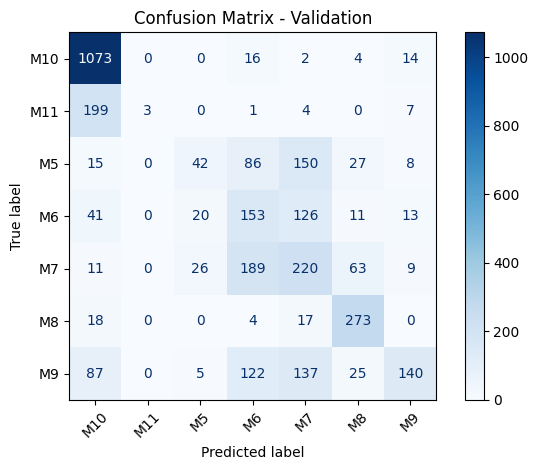

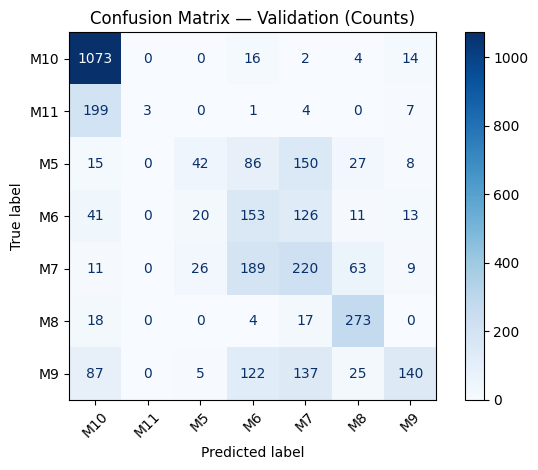

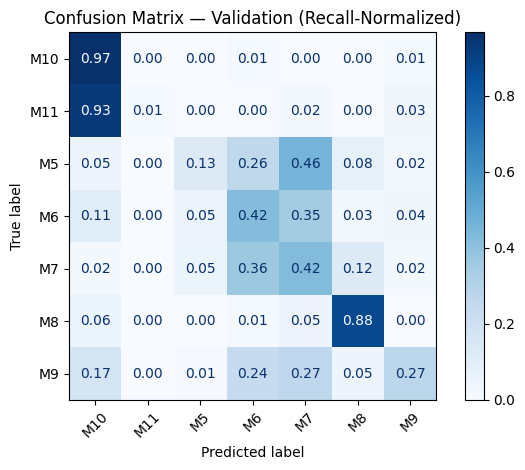

In [ ]:
# ========================
# 6) 在验证集评估（检查过拟合）
# ========================
yhat_va = best_model_et_kbest.predict(X_va)

labels_va = best_model_et_kbest.named_steps["clf"].classes_  # 模型训练得到的类别顺序
print("VAL Acc: %.3f | Macro-F1: %.3f | BalAcc: %.3f" % (
    accuracy_score(y_va, yhat_va),
    f1_score(y_va, yhat_va, average="macro"),
    balanced_accuracy_score(y_va, yhat_va)
))

print("\nValidation report:\n", classification_report(y_va, yhat_va, labels=labels_va, target_names=labels_va))

cm_va = confusion_matrix(y_va, yhat_va, labels=labels_va)
ConfusionMatrixDisplay(cm_va, display_labels=labels_va).plot(xticks_rotation=45, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Validation"); plt.tight_layout(); plt.show()


############################################3

## 集成 - 调用 validation 和 test 两版 的confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusions(y_true, y_pred, labels, title_prefix="Validation"):
    # 1) 计数版
    cm_counts = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(cm_counts, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix — {title_prefix} (Counts)")
    plt.tight_layout()
    plt.show()

    # 2) 归一化版（按真实标签行归一化，等价于各类召回）
    cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
    disp = ConfusionMatrixDisplay(cm_norm, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Blues", values_format=".2f")
    plt.title(f"Confusion Matrix — {title_prefix} (Recall-Normalized)")
    plt.tight_layout()
    plt.show()


## validation set的两版confusion matrix
labels_va = best_model_et_kbest.named_steps["clf"].classes_  # 用模型里的类顺序更稳
plot_confusions(y_va, yhat_va, labels_va, title_prefix="Validation")




---

---

---

---

---

---

---

---

---

---
